# The representation of women in the movie industry around the world

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import pycountry
import pycountry_convert as pc
import swifter

from functools import lru_cache
from scipy import stats
from itertools import islice
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import networkx as nx

from helpers_corenlp import *
from functions import *

from IPython.display import HTML
import plotly.graph_objs as go
from itertools import islice

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/ada/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Table of content**

1. [Data pre-processing](#Data-pre-processing)
    - [Part 1: CMU Movie Summary](#part1)
    - [Part 2: CoreNLP parsed movie summaries dataset](#part1.2)
    - [Part 3: IMDB Datasets](#part1.3)
    - [Part 4: Oscars Dataset](#part1.4)
    - [Part 5: Bechdel Dataset](#part1.5)
2. [Data Analysis](#Data-analysis)
    - [Part 1: Quantitative analysis of gender inequalities in movies](#part2.1)
    - [Part 2: Qualititative analysis of gender representation in movies](#part2.2)
    - [Part 3: Analysis of the reception of movies by the public](#part2.3)
    - [Part 4:  Analysis by geographical production region](#part2.4)

## STEP 1: DATA PRE-PROCESSING <a class="anchor" id="Data-pre-processing"></a>

---

In [3]:
current_directory = os.getcwd()

DATA_PATH = os.path.join(current_directory, 'MovieSummaries')
MOVIE_PATH = os.path.join(DATA_PATH, 'movie.metadata.tsv')
CHARACTER_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')
CHARACTER_TYPE_PATH = os.path.join(DATA_PATH, 'tvtropes.clusters.txt')
PLOT_SUMMARIES_PATH = os.path.join(DATA_PATH, 'plot_summaries.txt')
RATINGS_PATH = os.path.join(current_directory, 'Ratings_PreProcessed.tsv')

CORE_NLP_PATH = os.path.join(current_directory, 'corenlp')
CORE_NLP_GZ = CORE_NLP_PATH + "/corenlp_plot_summaries"
CORE_NLP_XML = CORE_NLP_PATH + "/corenlp_plot_summaries_xml"

IMDB_PATH = os.path.join(current_directory, 'IMDB')
IMDB_BASICS_PATH = IMDB_PATH + "/title.basics.tsv"
IMDB_RATINGS_PATH = IMDB_PATH + "/title.ratings.tsv"

BECHDEL_PATH = os.path.join(current_directory, 'bechdel_movies_2023_FEB.csv')

AWARDS_PATH = os.path.join(current_directory, 'the_oscar_award.csv')

CREDITS_PATH = os.path.join(current_directory, 'credits.csv')
MOVIES_CREDITS_PATH = os.path.join(current_directory, 'movies_metadata.csv')

## PART 1: CMU Movie Summary <a id="part1"></a>

We will use the files movies.metadata.tsv and characters.metadata.tsv .

In [4]:
# Load the datasets
headers_movies = ['WikiMovieID', 
                  'FreebaseMovieID', 
                  'MovieName', 
                  'ReleaseDate', 
                  'BORevenue', 
                  'Runtime',
                  'Languages', 
                  'Countries', 
                  'MovieGenre']

headers_characters = ['WikiMovieID', 
                      'FreebaseMovieID', 
                      'ReleaseDate', 
                      'CharacterName', 
                      'DoB', 
                      'Gender', 
                      'Height', 
                      'Ethnicity', 
                      'ActorName', 
                      'Age', 
                      'FreebaseActorMapID', 
                      'FreebaseCharacterID', 
                      'FreebaseActorID']

movies = pd.read_csv(MOVIE_PATH, sep='\t', names=headers_movies)
characters = pd.read_csv(CHARACTER_PATH, sep='\t', names=headers_characters)

In [5]:
nb_movie = movies['WikiMovieID'].nunique()
print(f'The movie dataset contains {nb_movie} movies')
movies.sample(3)

The movie dataset contains 81741 movies


,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre
79892,8807126,/m/027kdnd,Remember That Night,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/0d2rhq"": ""Concert film""}"
38824,33340379,/m/0h7q7mg,Pravegaya,NaN,NaN,NaN,"{""/m/02002f"": ""Sinhala Language""}",{},{}
49866,4102234,/m/0bj1yg,Katnip Kollege,1938,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film""}"


In [6]:
nb_char = len(characters.index)
print(f'The characters dataset contains {nb_char} characters')
print('Percentage of missing entries in the character.metadata dataset:')
print(100*characters[['FreebaseMovieID', 'ReleaseDate', 'CharacterName','DoB', 'Gender', 'Height', 'Ethnicity',
                        'ActorName', 'Age', 'FreebaseCharacterID','FreebaseActorID']].isna().sum() / len(characters))
characters.sample(3)

The characters dataset contains 450669 characters
Percentage of missing entries in the character.metadata dataset:
FreebaseMovieID         0.000000
ReleaseDate             2.217814
CharacterName          57.220488
DoB                    23.552763
Gender                 10.120288
Height                 65.645740
Ethnicity              76.466542
ActorName               0.272484
Age                    35.084064
FreebaseCharacterID    57.218269
FreebaseActorID         0.180842
dtype: float64


,WikiMovieID,FreebaseMovieID,ReleaseDate,CharacterName,DoB,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
91018,10153657,/m/02q3jn_,1965-10-01,NaN,1942-02-10,F,NaN,/m/0bpjh3,Madhabi Mukherjee,23.0,/m/02vbgj8,NaN,/m/07q3by
413670,5379935,/m/0dj7rs,2006,Pierre Reymond,1931-09-17,M,NaN,/m/03ts0c,Jean-Claude Carrière,74.0,/m/0k6ds8,/m/0h4xp3q,/m/0665bv
309502,23632489,/m/04q6jj4,2009,NaN,NaN,M,1.8,NaN,Tom Sandoval,NaN,/m/0gc0x9v,NaN,/m/0gc03nq


##### Gender

Our project focuses on differences between gender representation in movies; thus we keep only movies where we have gender information.

In [7]:
print('Percentage of missing gender entries in the character dataset:') 
print(100*characters[['Gender']].isna().sum() / len(characters))

# Keep only the rows for which we have the gender of the actor/actress
characters = characters.loc[characters['Gender'].isin(['F', 'M'])].copy(deep=True)
print(f'The character dataset contains {len(characters.index)} characters after filtering on the characters gender')

#Remove the movies where we don't have the gender of the actor/actress
movies = movies[movies['WikiMovieID'].isin(characters['WikiMovieID'])]

Percentage of missing gender entries in the character dataset:
Gender    10.120288
dtype: float64


The character dataset contains 405060 characters after filtering on the characters gender


##### Release date

In [8]:
# The movie 'Hunting Season' has an incorrect date: 1010 instead of 2010
characters['ReleaseDate'] = characters['ReleaseDate'].replace('1010-12-02', '2010-12-02')
movies['ReleaseDate'] = movies['ReleaseDate'].replace('1010-12-02', '2010-12-02')

# Convert the date in the column 'ReleaseDate' into datetime
characters_ReleaseDate_datatime = characters['ReleaseDate'].apply(convert_date)
movies_ReleaseDate_datatime = movies['ReleaseDate'].apply(convert_date)

# Add a column with the year of release only
characters['ReleaseYear'] = characters_ReleaseDate_datatime.dt.year.fillna(0).astype(int)
characters['ReleaseYear'] = characters['ReleaseYear'].astype('int64')
characters['ReleaseYear'].replace(0, np.nan, inplace=True)

movies['ReleaseYear'] = movies_ReleaseDate_datatime.dt.year.fillna(0).astype(int)
movies['ReleaseYear'] = movies['ReleaseYear'].astype('int64')
movies['ReleaseYear'].replace(0, np.nan, inplace=True)

In [9]:
characters.sample(2)

,WikiMovieID,FreebaseMovieID,ReleaseDate,CharacterName,DoB,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear
293712,14440087,/m/03d3lps,1939-05-19,NaN,1895-02-16,M,NaN,NaN,Vernon Dent,NaN,/m/04ddj2l,NaN,/m/026xmsr,1939.0
421632,27366108,/m/0bxy_8l,2010-05-14,Kripashankar,NaN,M,NaN,/m/0dryh9k,Mohan Joshi,NaN,/m/0cr6d_4,/m/0cr6dz9,/m/0cr6dz6,2010.0


In [10]:
movies.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear
7140,26408134,/m/0bbxn_j,Bharathchandran I.P.S.,2005-08-04,NaN,120.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/01jfsb"": ""Thriller"", ""/m/02kdv5l"": ""Action""}",2005.0
71191,2483471,/m/07h37d,Little Cigars,1973,NaN,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0gw5w78"": ""G...",1973.0


##### Age

In [11]:
# Replace null or negative age values by NaN
characters['Age'] = characters['Age'].apply(lambda x: np.nan if x <= 0 else x)

##### Deal with dictionnaries

In [12]:
# Convert the str-like dictionaries to dictionaries
movies['Countries'] = movies['Countries'].apply(ast.literal_eval)
movies['MovieGenre'] = movies['MovieGenre'].apply(ast.literal_eval)
movies['Languages'] = movies['Languages'].apply(ast.literal_eval)

In [13]:
movies.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear
37365,2772791,/m/02k_8x6,Shame,1968,NaN,103.0,"{'/m/06mp7': 'Swedish Language', '/m/02h40lc':...",{'/m/0d0vqn': 'Sweden'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",1968.0
17834,20903198,/m/05b2s9p,Jaan Hazir Hai,1975,NaN,NaN,{'/m/03k50': 'Hindi Language'},{'/m/03rk0': 'India'},{},1975.0


For the analysis we consider that:
- If a movie has several genres, we will keep the one that appears in the 16 major genres, and if several are in the 16 major genres, we keep the first one.
- If none is in the 16 major genre, or if the genre is not given, then we drop the row

In [14]:
all_unique_genres = set()

# Get all the movie genres
movies['MovieGenre'].apply(lambda x: all_unique_genres.update(x.values()) if isinstance(x, dict) else None)

# Initialize dictionary with keys and values set to 0
genres_count = {genre: 0 for genre in all_unique_genres}

# Count the occurence of each genre
for row in movies['MovieGenre']:
    for key, value in row.items():
        genres_count[value]+=1
        
# Sort the dictionary by values in descending order
genres_count = dict(sorted(genres_count.items(), key=lambda item: item[1], reverse=True))

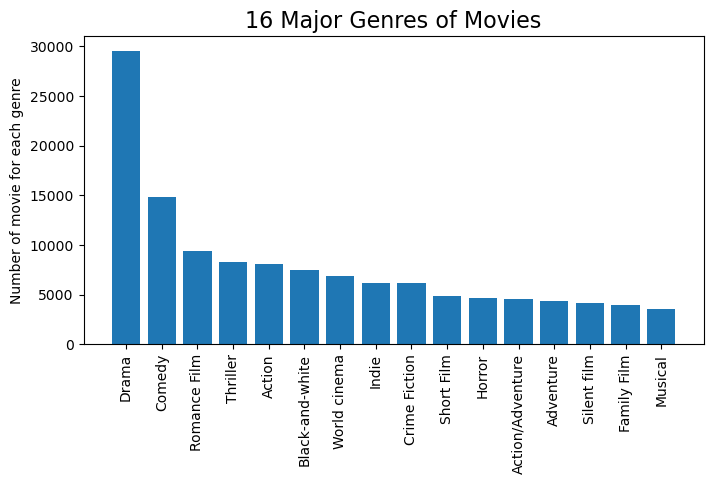

In [15]:
plt.figure(figsize=(8, 4))

# Keep the first 16 major genres
major_16_genres = dict(islice(genres_count.items(), 16))

x = np.arange(len(major_16_genres))

plt.bar(x, major_16_genres.values())
plt.xticks(x, major_16_genres.keys(), rotation='vertical')
plt.title('16 Major Genres of Movies', fontsize=16)
plt.ylabel('Number of movie for each genre')
plt.show()

In [16]:
# Keep the first 16 major genres
major_16_genres = dict(islice(genres_count.items(), 16))

fig = go.Figure(data=[
    go.Bar(
            x = np.arange(len(major_16_genres)),
            y = list(major_16_genres.values()),
            marker= dict(color = 'rgba(0, 158, 115, 0.5)')
        )]
)

fig.update_layout(
    autosize=False,
    width=700,
    height=500,
    title= "16 Major Genres of Movies",
    xaxis_title="Genres",
    yaxis_title= "Number of movie for each genre"
)

# Add custom x-axis tick labels and rotate them vertically
fig.update_xaxes(
    tickvals=np.arange(len(major_16_genres)),
    ticktext=list(major_16_genres.keys()),
    tickangle=-90
)

fig.write_html("plots/movie_genres.html")
fig.show()

In [17]:
# List of rows to drop 
rows_to_drop = []

for index, row in movies.iterrows():
    movie_genre = row['MovieGenre']
    
    # If there is one genre only, drop the row if not in the 16 major genre
    #if len(movie_genre) == 1 and list(movie_genre.values())[0] not in major_16_genres:
    #    rows_to_drop.append(index)
        
    # If there is no genre, drop the corresponding row
    if not bool(movie_genre):
        rows_to_drop.append(index)
            
    # If there are multiple genres        
    else:
        count = 0  # To keep the first value only
        for key, value in movie_genre.items():
            if value in major_16_genres:
                if count == 0:
                    value_to_keep = value
                    key_to_keep = key
                    count = 1
                    break
        
        if count == 0: # if none of the genre is in the first 16 genre, keep the first one

            movies.at[index, 'MovieGenre'] = {list(movie_genre.keys())[0]: list(movie_genre.values())[0]}

        #if count == 0:  # If none of the genres is in the major_16_genres, drop the row
        #    rows_to_drop.append(index)

        if count == 1:
            movies.at[index, 'MovieGenre'] = {key_to_keep: value_to_keep}

# Create a new DataFrame with only the rows to keep
movies = movies.drop(rows_to_drop)
movie_counts = movies['WikiMovieID'].nunique()
print(f'We are left with {movie_counts} movies')

We are left with 62455 movies


##### Merge the characters & movies datasets

In [18]:
# Merge the 2 datasets according to the common columns, and drop the columns that we don't need
# We perform an inner join to populate characters with movies
cmu = movies.merge(characters, how='inner', on=['WikiMovieID', 'FreebaseMovieID', 'ReleaseDate', 'ReleaseYear'])
cmu = cmu.drop(['DoB', 'Height', 'Runtime'], axis=1).copy(deep=True)

print(f'The cmu dataset contains {len(cmu.index)} entries')
cmu.sample(2)

The cmu dataset contains 401059 entries


,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,CharacterName,Gender,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
193405,18545216,/m/04g13dq,Bitch Slap,2009-05-16,199436.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2009.0,Camero,F,NaN,America Olivo,31.0,/m/07r2f8g,/m/09knnqg,/m/04y8l1h
205890,2212695,/m/06wbq4,Alice in Wonderland,1976-12-10,90000000.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/04t36': 'Musical'},1976.0,Alice,F,NaN,Kristine DeBell,22.0,/m/0jt7bx,/m/0h50v5c,/m/03f7pz


In [19]:
print('Percentage of missing entries in the cmu dataset:') 
print(100*cmu[['WikiMovieID', 'FreebaseMovieID', 'MovieName', 'ReleaseDate', 'BORevenue', 'ReleaseYear', 
               'CharacterName','Gender', 'Ethnicity', 'ActorName', 'Age', 'FreebaseCharacterID',
               'FreebaseActorID', 'FreebaseActorMapID']].isna().sum() / len(cmu))

print(f"\nLanguages {percent_missing_strdict(cmu['Languages']):.2f}%")
print(f"Countries {percent_missing_strdict(cmu['Countries']):.2f}%")
print(f"MovieGenre {percent_missing_strdict(cmu['MovieGenre']):.2f}%")                                                                                  

Percentage of missing entries in the cmu dataset:
WikiMovieID             0.000000
FreebaseMovieID         0.000000
MovieName               0.000000
ReleaseDate             2.336065
BORevenue              76.506948
ReleaseYear             2.336065
CharacterName          53.946177
Gender                  0.000000
Ethnicity              73.910821
ActorName               0.002992
Age                    28.245470
FreebaseCharacterID    53.944183
FreebaseActorID         0.000000
FreebaseActorMapID      0.000000
dtype: float64

Languages 7.27%
Countries 3.46%
MovieGenre 0.00%


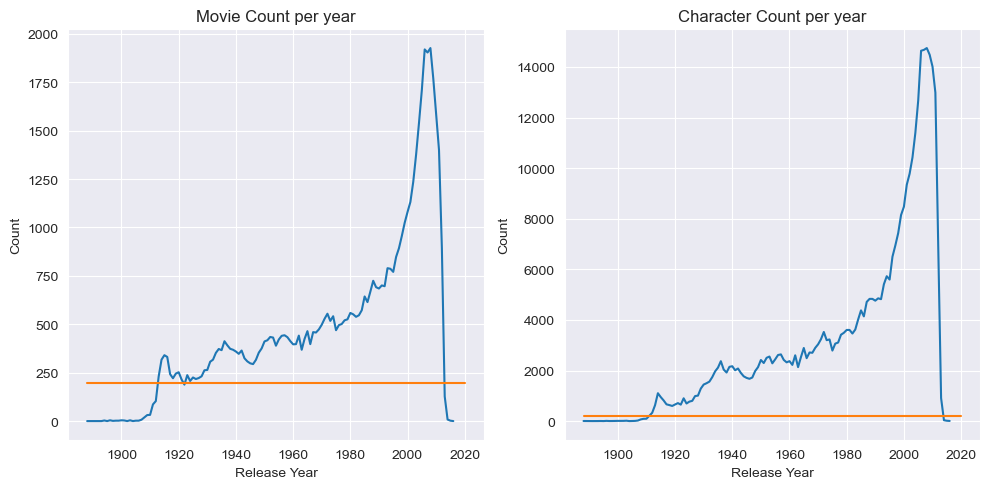

In [20]:
# Plot the number of movies and of characters per year
movie_count_per_year = cmu.groupby(['ReleaseYear']).agg({'WikiMovieID' : 'nunique'})
character_count_per_year = cmu.groupby(['ReleaseYear']).agg({'Gender': 'count'})

sns.set_style("darkgrid")

fig, (ax1, ax2) = plt.subplots(1,2,figsize= (10,5))
ax1.plot(movie_count_per_year)
ax1.plot([1888, 2020], [200, 200])
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Count')
ax1.set_title('Movie Count per year')

ax2.plot(character_count_per_year)
ax2.plot([1888, 2020], [200, 200])
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Count')
ax2.set_title('Character Count per year')

plt.tight_layout()
plt.show()

In [21]:
# Keep only movies between 1925 and 2012 to have at least 200 movies per year and at least 100 characters per year.
cmu = cmu.loc[(cmu['ReleaseYear'] >= 1925) & (cmu['ReleaseYear'] <= 2012)].copy(deep=True)
print(f'The cmu dataset contains {len(cmu.index)} entries after filtering to have at least 200 movies and 100 characters per year.')

The cmu dataset contains 380822 entries after filtering to have at least 200 movies and 100 characters per year.


### Add geographical data to our dataset

We will perform a geographical analysis; for this purpose, we will create specialized datasets.  

In [22]:
#Initial number of rows in the movies dataset
nb_row_countries = len(movies)

# Create a new dataset from movies where we remove the rows in the 'Countries' column that lack information about countries.
movies_geo = movies[movies['Countries'].apply(lambda x: len(x)!=0)].copy(deep=True)

num_rows_dropped = nb_row_countries-len(movies_geo)
percentage_rows_dropped = (num_rows_dropped / nb_row_countries) * 100
print(f'We dropped {num_rows_dropped} rows, corresponding to {percentage_rows_dropped:.2f}% of our original movies dataset.')

We dropped 4668 rows, corresponding to 7.47% of our original movies dataset.


In [23]:
# We convert the column type from dictionaries to a list of strings.
movies_geo['Countries'] = movies_geo['Countries'].apply(lambda x: [val for val in x.values()])

To facilitate the analysis, we will utilize the ISO databases available in the pycountry library for standardized country names.

In [24]:
movies_geo['Countries'] = movies_geo['Countries'].swifter.apply(bulkFindCountries)
# Replace 'not found' by None 
movies_geo['Countries'] = movies_geo['Countries'].apply(process_countries).copy(deep=True)

Pandas Apply: 100%|██████████| 57787/57787 [00:02<00:00, 22243.95it/s]


In [25]:
# Filter out NaN values and keep only the countries for which we have the alpha_2 code
length_before = len(movies_geo)
movies_geo = movies_geo.dropna(subset=['Countries']).copy(deep=True)
length_after = len(movies_geo)

print(f'By filtering out Nan values, we dropped {length_before-length_after} rows, corresponding to {((length_before-length_after)/length_before)*100:.2f}% of our dataset.')
print(f'The filtered dataset contains {length_after} movies.')

By filtering out Nan values, we dropped 661 rows, corresponding to 1.14% of our dataset.
The filtered dataset contains 57126 movies.


In [26]:
# Then we can determine the continent using the alpha_2 code
movies_geo['Continent'] = movies_geo['Countries'].apply(lambda x: [pc.country_alpha2_to_continent_code(country) for country in x]).copy(deep=True)

In [27]:
# If a row contains multiple occurrences of the same continent, eliminate the duplicates within the list
movies_geo['Continent'] = movies_geo['Continent'].apply(lambda x: list(dict.fromkeys(x)) if isinstance(x, list) else x).copy(deep=True)

In [28]:
# Remove the rows for which we have more than one unique continent
length_before = len(movies_geo)

movies_geo = movies_geo[movies_geo['Continent'].apply(lambda x: len(x) <= 1)].copy(deep=True)

length_after = len(movies_geo)
print(f'We dropped {length_before-length_after} rows, corresponding to {((length_before-length_after)/length_before)*100:.2f}% of our dataset.')
print(f'The filtered dataset contains {length_after} movies.')

We dropped 4062 rows, corresponding to 7.11% of our dataset.
The filtered dataset contains 53064 movies.


In [29]:
# Change the data type of the 'Continent' column from a list to a string since it now contains lists with only one element
movies_geo['Continent'] = movies_geo['Continent'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Change the data type of the 'Countries' column from a list to a string
movies_geo['Countries'] = movies_geo['Countries'].apply(lambda x: x[0] if isinstance(x, list) else x)
movies_geo.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear,Continent
1443,20562478,/m/026x4tt,Devadasy,2000,NaN,90.0,{'/m/0999q': 'Malayalam Language'},IN,{'/m/0jxy': 'Anime'},2000.0,AS
5645,25829262,/m/09v6qpt,American Soldiers,2005,NaN,110.0,{},US,{'/m/01jfsb': 'Thriller'},2005.0,NA


In [30]:
print(f'Our final dataset contains {len(movies_geo.index)} movies.')

Our final dataset contains 53064 movies.


Merge the movies_geo dataset with characters for our future analysis.

In [31]:
# Merge the 2 datasets according to the common columns, and drop the columns that we don't need
cmu_geo = movies_geo.merge(characters, how='inner', on=['WikiMovieID', 'FreebaseMovieID', 'ReleaseDate', 'ReleaseYear'])
cmu_geo = cmu_geo.drop(['DoB', 'Height', 'Runtime'], axis=1).copy(deep=True)

print(f'The cmu_geo dataset contains {len(cmu_geo.index)} entries')
cmu_geo.sample(2)

The cmu_geo dataset contains 346051 entries


,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,Continent,CharacterName,Gender,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
34931,5454727,/m/0dmmwk,Cash McCall,1960-01-27,NaN,{'/m/02h40lc': 'English Language'},US,{'/m/02l7c8': 'Romance Film'},1960.0,NA,Grant Austen,M,NaN,Dean Jagger,56.0,/m/04m9sjf,/m/0bxk6y3,/m/03bpgs
235442,6369086,/m/0g2tfj,Doodeind,2006-08-03,NaN,"{'/m/02bv9': 'Dutch Language', '/m/02h40lc': '...",NL,{'/m/01jfsb': 'Thriller'},2006.0,EU,Chris,M,NaN,Everon Jackson Hooi,24.0,/m/0j8kzxc,/m/0j8kzxg,/m/0bh2_sl


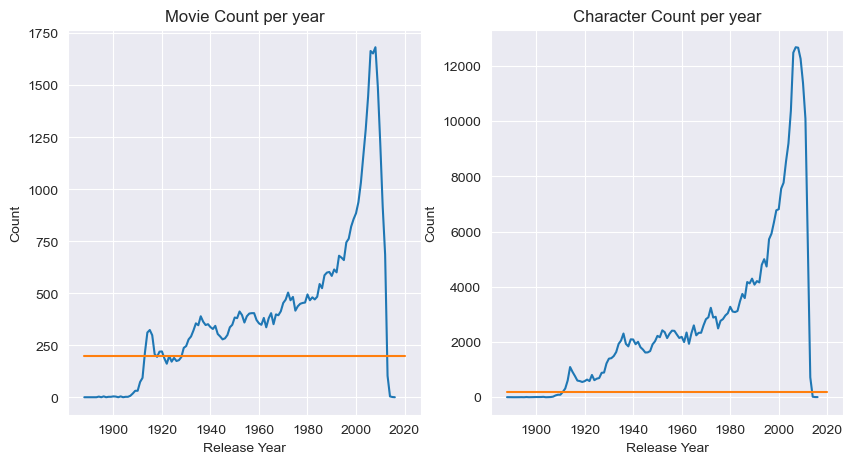

In [32]:
movie_geo_count_per_year = cmu_geo.groupby(['ReleaseYear']).agg({'WikiMovieID' : 'nunique'})
character_geo_count_per_year = cmu_geo.groupby(['ReleaseYear']).agg({'Gender': 'count'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize= (10,5))
ax1.plot(movie_geo_count_per_year)
ax1.plot([1888, 2020], [200, 200])
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Count')
ax1.set_title('Movie Count per year')

ax2.plot(character_geo_count_per_year)
ax2.plot([1888, 2020], [200, 200])
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Count')
ax2.set_title('Character Count per year')

plt.show()

In [33]:
# Keep only movies between 1930 and 2012 to have at least 200 movies per year and at least 100 characters per year
cmu_geo = cmu_geo.loc[(cmu_geo['ReleaseYear'] >= 1930) & (cmu_geo['ReleaseYear'] <= 2012)].copy(deep=True)
print(f'The cmu_geo dataset contains {len(cmu_geo.index)} entries after filtering to have at least 200 movies and 100 characters per year')

The cmu_geo dataset contains 326134 entries after filtering to have at least 200 movies and 100 characters per year


In [34]:
print('Percentage of missing entries in the cmu_geo dataset:')
print(100*cmu[['WikiMovieID', 'FreebaseMovieID', 'MovieName', 'ReleaseDate', 'BORevenue',
               'ReleaseYear', 'CharacterName','Gender', 'Ethnicity','ActorName', 'Age',
               'FreebaseCharacterID','FreebaseActorID', 'FreebaseActorMapID']].isna().sum() / len(cmu_geo))

print(f"\nLanguages {percent_missing_strdict(cmu_geo['Languages']):.2f}%") 
print(f"Countries {percent_missing_strdict(cmu_geo['Countries']):.2f}%") 
print(f"MovieGenre {percent_missing_strdict(cmu_geo['MovieGenre']):.2f}%") 

Percentage of missing entries in the cmu_geo dataset:
WikiMovieID             0.000000
FreebaseMovieID         0.000000
MovieName               0.000000
ReleaseDate             0.000000
BORevenue              87.952805
ReleaseYear             0.000000
CharacterName          61.723709
Gender                  0.000000
Ethnicity              86.002686
ActorName               0.003679
Age                    28.981646
FreebaseCharacterID    61.721256
FreebaseActorID         0.000000
FreebaseActorMapID      0.000000
dtype: float64

Languages 4.78%
Countries 0.00%
MovieGenre 0.00%


### Proportion of female per movie

In [35]:
women_cmu_geo = cmu_geo.loc[cmu_geo['Gender']=='F'].copy(deep=True)
men_cmu_geo = cmu_geo.loc[cmu_geo['Gender']=='M'].copy(deep=True)

In [36]:
#Create the dataframe
df_gender_proportion_by_movie_geo = pd.DataFrame()

#Add the number of male and female characters of each movie
df_gender_proportion_by_movie_geo['MaleCharacters'] = men_cmu_geo.groupby(['WikiMovieID', 'Countries', 'Continent'])['Gender'].count()
df_gender_proportion_by_movie_geo['FemaleCharacters'] = women_cmu_geo.groupby(['WikiMovieID', 'Countries', 'Continent'])['Gender'].count()

#Change Nan to O 
df_gender_proportion_by_movie_geo['FemaleCharacters'] = df_gender_proportion_by_movie_geo['FemaleCharacters'].replace(np.nan, 0)
df_gender_proportion_by_movie_geo['MaleCharacters'] = df_gender_proportion_by_movie_geo['MaleCharacters'].replace(np.nan, 0)

#Add the total number of characters of each movie
df_gender_proportion_by_movie_geo['TotalNumberofCharacters'] = cmu_geo.groupby(['WikiMovieID', 'Countries', 'Continent'])['Gender'].count()

#Add the release year of each movie
df_gender_proportion_by_movie_geo = df_gender_proportion_by_movie_geo.merge(cmu_geo[['ReleaseYear', 'WikiMovieID', 'Countries', 'Continent']], how='left', left_index=True, right_on=['WikiMovieID' , 'Countries', 'Continent'] )

#Calculate the proportion of male and female characters per movie
df_gender_proportion_by_movie_geo['PercentageofFemale'] = df_gender_proportion_by_movie_geo['FemaleCharacters'] / df_gender_proportion_by_movie_geo['TotalNumberofCharacters'] * 100
df_gender_proportion_by_movie_geo['PercentageofMale'] = df_gender_proportion_by_movie_geo['MaleCharacters'] / df_gender_proportion_by_movie_geo['TotalNumberofCharacters'] * 100

#Remove duplicated rows
df_gender_proportion_by_movie_geo = df_gender_proportion_by_movie_geo.drop_duplicates(subset=['WikiMovieID']).copy(deep=True)

In [37]:
filtered_gender_proportion_by_movie_geo = df_gender_proportion_by_movie_geo.query("Countries in ['US', 'IN'] or Continent == 'EU'")

### Part 2: The Movies Dataset

We use this dataset to find the main character of movies.

In [38]:
credits = pd.read_csv(CREDITS_PATH)
display(credits)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862
...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506


In [39]:
movies_credits = pd.read_csv(MOVIES_CREDITS_PATH)
display(movies_credits)

/var/folders/xy/g9qngpq914dbt048l9v974zh0000gn/T/ipykernel_2900/600144018.py:1: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [40]:
movies_credits['id'] = pd.to_numeric(movies_credits['id'], errors='coerce')
movies_credits = movies_credits.dropna(subset=['id'])
movies_credits['id'] = movies_credits['id'].astype(int)

In [41]:
# Merge datasets based on 'id' column with a left join
credits = pd.merge(credits, movies_credits[['id', 'title']], on='id', how='left')

# Display the merged DataFrame
display(credits)

,cast,crew,id,title
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,Toy Story
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,Jumanji
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,Grumpier Old Men
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,Waiting to Exhale
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,Father of the Bride Part II
...,...,...,...,...
45533,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050,Subdue
45534,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109,Century of Birthing
45535,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758,Betrayal
45536,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506,Satan Triumphant


In [42]:
# Convert the str-like dictionaries to dictionaries
credits['cast'] = credits['cast'].apply(ast.literal_eval)

In [43]:
def find_main_char(cast):
    """
    Find the main character in the cast list based on the minimum cast_id.

    Parameters:
    - cast (list): A list of dictionaries representing the cast.

    Returns:
    - tuple: A tuple containing the main character details (character, actor, gender, cast_id).
    - None: If the input list is empty.
    """
    if not cast:
        return None
    
    # Find the minimum cast_id
    min_id = min(el['cast_id'] for el in cast)


    # Find the details of the main character with the minimum cast_id
    main_char, main_actor, main_gender, main_cast = next(
        (el['character'], el['name'], el['gender'], el['cast_id']) for el in cast if el['cast_id'] == min_id
    )

    return main_char, main_actor, main_gender, main_cast

In [44]:
credits['main_char'], credits['main_actor'], credits['main_char_gender'] = zip(*credits['cast'].apply(lambda x: find_main_char(x) if x else (None, None, None)).tolist())
display(credits)

,cast,crew,id,title,main_char,main_actor,main_char_gender
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,Toy Story,Woody (voice),Tom Hanks,2.0
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,Jumanji,Alan Parrish,Robin Williams,2.0
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,Grumpier Old Men,Max Goldman,Walter Matthau,2.0
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,Waiting to Exhale,Savannah 'Vannah' Jackson,Whitney Houston,1.0
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,Father of the Bride Part II,George Banks,Steve Martin,2.0
...,...,...,...,...,...,...,...
45533,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050,Subdue,,Leila Hatami,1.0
45534,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109,Century of Birthing,Sister Angela,Angel Aquino,1.0
45535,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758,Betrayal,Emily Shaw,Erika Eleniak,1.0
45536,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506,Satan Triumphant,,Iwan Mosschuchin,2.0


In [45]:
#Drop the movies where we don't have the main character's gender
credits = credits.dropna(subset=['main_char_gender'])
credits = credits[credits['main_char_gender'] != 0]

#Reformat the main_char_gender column with F or M
credits['main_char_gender'] = credits['main_char_gender'].map({1.0: 'F', 2.0: 'M'})
display(credits)

,cast,crew,id,title,main_char,main_actor,main_char_gender
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,Toy Story,Woody (voice),Tom Hanks,M
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,Jumanji,Alan Parrish,Robin Williams,M
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,Grumpier Old Men,Max Goldman,Walter Matthau,M
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,Waiting to Exhale,Savannah 'Vannah' Jackson,Whitney Houston,F
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,Father of the Bride Part II,George Banks,Steve Martin,M
...,...,...,...,...,...,...,...
45532,"[{'cast_id': 1, 'character': 'Sir Robert Hode'...","[{'credit_id': '52fe44439251416c9100a899', 'de...",30840,Robin Hood,Sir Robert Hode,Patrick Bergin,M
45533,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050,Subdue,,Leila Hatami,F
45534,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109,Century of Birthing,Sister Angela,Angel Aquino,F
45535,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758,Betrayal,Emily Shaw,Erika Eleniak,F


In [46]:
credits = credits.drop(['cast', 'crew'], axis=1)
display(credits)

,id,title,main_char,main_actor,main_char_gender
0,862,Toy Story,Woody (voice),Tom Hanks,M
1,8844,Jumanji,Alan Parrish,Robin Williams,M
2,15602,Grumpier Old Men,Max Goldman,Walter Matthau,M
3,31357,Waiting to Exhale,Savannah 'Vannah' Jackson,Whitney Houston,F
4,11862,Father of the Bride Part II,George Banks,Steve Martin,M
...,...,...,...,...,...
45532,30840,Robin Hood,Sir Robert Hode,Patrick Bergin,M
45533,439050,Subdue,,Leila Hatami,F
45534,111109,Century of Birthing,Sister Angela,Angel Aquino,F
45535,67758,Betrayal,Emily Shaw,Erika Eleniak,F


### Plot summaries

In [47]:
plot_summaries = pd.read_csv(PLOT_SUMMARIES_PATH, sep = '\t', header=None, names = ['WikiMovieID', 'Summary'])

display(plot_summaries)

,WikiMovieID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


We will calculate the sentiment score of the summary plot of each movie, which is comprised between -1 (most negative film) and +1 (most positive film). We use the spacy pipeline *spacytextblob*. 

In [48]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("spacytextblob")

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/spacy/util.py:910: UserWarning:

[W095] Model 'en_core_web_lg' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate



In [50]:
#Calculate the sentiment score of each movie
plot_summaries['Summary'] = plot_summaries.Summary.apply(lambda x : nlp(x))
plot_summaries['Sentiment'] = plot_summaries.Summary.apply(lambda x : x._.blob.polarity)
display(plot_summaries)

,WikiMovieID,Summary,Sentiment
0,23890098,"(Shlykov, ,, a, hard, -, working, taxi, driver...",0.200000
1,31186339,"(The, nation, of, Panem, consists, of, a, weal...",0.045261
2,20663735,"(Poovalli, Induchoodan, , is, sentenced, for,...",0.049550
3,2231378,"(The, Lemon, Drop, Kid, ,, a, New, York, City,...",0.030550
4,595909,"(Seventh, -, day, Adventist, Church, pastor, M...",0.063913
...,...,...,...
42298,34808485,"(The, story, is, about, Reema, ,, a, young, Mu...",0.146667
42299,1096473,"(In, 1928, Hollywood, ,, director, Leo, Andrey...",0.155081
42300,35102018,"(American, Luthier, focuses, on, Randy, Parson...",0.156000
42301,8628195,"(Abdur, Rehman, Khan, ,, a, middle, -, aged, d...",0.104762


## PART 3: CoreNLP parsed movie summaries <a id="part1.2"></a>

We process the files contained in the corenlp_plot_summaries.tar archive.

All functions used for this part and other helpers are in the helpers_corenlp.py file.

In [51]:
# First we extract the files contained in the tar file into .xml files
load_corenlp_data()

From the Bamman et al. paper [1], we know what type of dependencies we need to look for in the plot summary trees:
- for agent verbs: verbs for which the entity is
   - nsubj
   - agent
- for patient verbs: verbs for which the entity is
   - dobj
   - nsubjpass
   - iobj
   - any prepositional argument prep_*
- for attributes: adjectives and common noun words that relate to the mention as adjecti- val modifiers, noun-noun compounds, appos- itives, or copulas: 
   - nsubj or appos governors of a character mention
   - nsubj, appos, amod, nn dependents of a character mention

This search is directly implemented in a function.

The idea is also to count the number of mentions of each character of a movie and then use this number of mentions as a proxy for identifying the main character. Thus in our case we define the main character as the moset mentioned one in the plot summary.

In [52]:
# Get the Wikipedia movie id from the Lord of the Ring movies
test_ids = characters[characters['CharacterName'] == 'Aragorn']['WikiMovieID'].values

In [53]:
# Get the main character names from the Lord of the Ring movies
for id in test_ids:
    movie_xml = str(id) + '.xml'
    print(get_main_character(movie_xml))

Frodo
Frodo Baggins
Frodo
Frodo


As we expect, we extract Frodo as the main character of all the Lord of the Ring movies.
But we see that depending on the plot summary, the character's full name extracted can be different...

We thus need to check in a bidirectional way what the "fullest" name used is between the name extracted from the summary and the one used in the character metadata before merging.

In [54]:
lst = []
# we only iterate over movies for which both character and movie metadata is available
ids = np.intersect1d(movies['WikiMovieID'].unique(), characters['WikiMovieID'].unique())
for id in ids[:100]:
    # We extract the data from the .xml files into a list of dictionaries
    if os.path.isfile(CORE_NLP_XML + '/' + str(id) + '.xml'):
        lst = lst + get_list_movie(str(id) + '.xml')
        cmu_characters = list(cmu[cmu['WikiMovieID'] == id].CharacterName)
        xml_characters = list(get_characters_from_xml(str(id) + '.xml'))
        characters = cmu_characters + xml_characters
        # type cast to string
        characters = [str(x) for x in characters]
        # get the full names of the characters
        full_names_dict = get_full_names_dict(characters)
        # replace cmu CharacterName by the full name in that movie
        cmu.loc[cmu['WikiMovieID'] == id, 'CharacterName'] = cmu.loc[cmu['WikiMovieID'] == id, 'CharacterName'].apply(lambda x: full_names_dict[x] if x in full_names_dict.keys() else x)

# We convert the list of dictionaries into a dataframe
df_corenlp = pd.DataFrame(lst)
df_corenlp.head()

,WikiMovieID,CharacterName,Agent verbs,Patient verbs,Attributes,Mentions,MainCharacter
0,3217,Lord Arthur,[],[],[],3,False
1,3217,Henry,[],"{ set, enslaved}",[],2,False
2,3217,Sheila,[],"{ saving, transformed, attracted, captured}",[],4,True
3,3217,Ash,{slays},"{ pursues, thrown, determined, celebrated, ...",[],2,False
4,3217,Klaatu,[],{say},[],1,False


The code takes a lot of time to run so for now we only do it for a few movies (for the first 100 IDs).

We need to typecast so that we can merge!

In [55]:
# Change the type of the WikiMovieID column to int64
df_corenlp['WikiMovieID'] = df_corenlp['WikiMovieID'].astype('int64')

In [56]:
cmu_corenlp = cmu.merge(df_corenlp, how='inner', on=['WikiMovieID', 'CharacterName'])

In [57]:
cmu_corenlp.head()

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,CharacterName,...,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,Agent verbs,Patient verbs,Attributes,Mentions,MainCharacter
0,8695,/m/02dwj,Dr. Strangelove or: How I Learned to Stop Worr...,1964-01-29,9164370.0,"{'/m/02h40lc': 'English Language', '/m/06b_j':...",{'/m/07ssc': 'United Kingdom'},{'/m/07s9rl0': 'Drama'},1964.0,Dr. Strangelove,...,Peter Sellers,38.0,/m/02nwt1n,/m/02nwt1q,/m/063_t,[],[],[],3,False
1,8695,/m/02dwj,Dr. Strangelove or: How I Learned to Stop Worr...,1964-01-29,9164370.0,"{'/m/02h40lc': 'English Language', '/m/06b_j':...",{'/m/07ssc': 'United Kingdom'},{'/m/07s9rl0': 'Drama'},1964.0,Merkin Muffley,...,Peter Sellers,38.0,/m/05dc8rr,/m/02s2g7,/m/063_t,{gives},{shocked},[],5,False
2,30575,/m/07j6w,Twelve Monkeys,1995-12-27,168839459.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},1995.0,James Cole,...,Bruce Willis,40.0,/m/0k7f2_,/m/04drwvq,/m/0h7pj,{witnessing},"{ locked, interviewed, restrained, shot, g...","{ young, living}",6,True
3,30575,/m/07j6w,Twelve Monkeys,1995-12-27,168839459.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},1995.0,Dr. Kathryn Railly,...,Madeleine Stowe,37.0,/m/0k7f34,/m/0h2ldj5,/m/01xldv,{spots},{kidnaps},[],6,False
4,30575,/m/07j6w,Twelve Monkeys,1995-12-27,168839459.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},1995.0,Jeffrey Goines,...,Brad Pitt,32.0,/m/0k7f39,/m/04dk4xh,/m/0c6qh,{suggests},{encounters},[],5,False


We get a dataframe with character information extracted from the movie plot summary joined with metadata from the CMU movie corpus. The information extracted from the CoreNLP parsed summaries will be used to cluster characters based on their depiction in the summary.

## PART 4: IMDB datasets <a id="part1.3"></a>

In [58]:
# Load the datasets
IMDB_title = pd.read_csv(IMDB_BASICS_PATH,sep='\t', low_memory=False)
IMDB_ratings = pd.read_csv(IMDB_RATINGS_PATH, sep = '\t')

In [59]:
display(IMDB_title)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10295872,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10295873,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10295874,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10295875,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [60]:
display(IMDB_ratings)

,tconst,averageRating,numVotes
0,tt0000001,5.7,2005
1,tt0000002,5.8,269
2,tt0000003,6.5,1908
3,tt0000004,5.5,178
4,tt0000005,6.2,2688
...,...,...,...
1366964,tt9916730,7.6,11
1366965,tt9916766,7.0,22
1366966,tt9916778,7.2,36
1366967,tt9916840,8.8,6


In [61]:
# Only choose the rows which correspond to data of a movie
IMDB_title = IMDB_title[IMDB_title['titleType'] == 'movie'].copy(deep=True)

# Merge the dataset with the titles and the dataset with the ratings
df_IMDB = IMDB_title.merge(IMDB_ratings, left_on='tconst', right_on='tconst')
display(df_IMDB)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.3,207
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.3,484
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.1,15
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,855
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.0,21
...,...,...,...,...,...,...,...,...,...,...,...
299653,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,\N,84,Thriller,5.8,1448
299654,tt9916362,movie,Coven,Akelarre,0,2020,\N,92,"Drama,History",6.4,5605
299655,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,\N,\N,"Adventure,History,War",3.5,17
299656,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,\N,123,Drama,8.6,7


Let's check if there are aberrant values in the averageRating column, for example negative values or values higher than 10.

In [62]:
df_IMDB.describe()

,averageRating,numVotes
count,299658.000000,2.996580e+05
mean,6.175995,3.619263e+03
std,1.370387,3.570741e+04
min,1.000000,5.000000e+00
25%,5.300000,1.900000e+01
50%,6.300000,6.100000e+01
75%,7.100000,3.130000e+02
max,10.000000,2.816055e+06


There are no aberrant values in the averageRating column.

### Calculate the average rating of each movie

We want to have the average rating of each movie. In df_IMDB, we have several ratings for each movies; indeed, the same movie (characterized by its 'orginialTitle') has a grade for each 'primaryTitle' used.
In the calculation of the average rating per originalTitle, we will ponderate the rating per primaryTitle with the number of votes per primaryTitle.
Then, we will calculate the average rating across all primaryTitle i for an originalTitle as :  
$Average\, Rating\, of\, originalTitle =\frac{\sum {average\,rating\,of\,primaryTitle(i) \times number\,of\,votes\,of\,primaryTitle(i)}} {\sum{number\,of\,votes\,of\,primaryTitle(i)}}$

In [63]:
# Create datasets of average ratings of a movie considering the ratings of movies with titles in different languages

# Calculate average_rating_language(i) * number_of_votes_language(i) (ponderate)
df_IMDB['mult_ratings'] = df_IMDB['averageRating']*df_IMDB['numVotes']

average_ratings = pd.DataFrame()
average_ratings['sum_of_mult_ratings'] = df_IMDB[['originalTitle', 'mult_ratings']].groupby('originalTitle').sum()
average_ratings['total_vote'] = df_IMDB[['originalTitle', 'numVotes']].groupby('originalTitle').sum()
average_ratings['total_average_rating'] = average_ratings['sum_of_mult_ratings']/average_ratings['total_vote']

average_ratings = average_ratings.reset_index(level=0)

# Create a new dataframe with the movies primary titles, release years, and average ratings.
ratings = df_IMDB.merge(average_ratings[['total_average_rating', 'originalTitle', 'total_vote']], how = 'left', on = 'originalTitle')
ratings=ratings[['primaryTitle', 'startYear', 'total_average_rating', 'total_vote']]
ratings=ratings.drop_duplicates(subset=['primaryTitle', 'startYear' ]).copy(deep=True)

# Prepare the dataset to be merged with CMU movies.
ratings= ratings.rename(columns = {"primaryTitle" : "MovieName", "startYear" : "ReleaseYear", "total_average_rating" : "AverageRating", "total_vote" : "NumberofVotes"})
ratings["ReleaseYear"]=pd.to_datetime(ratings["ReleaseYear"], errors='coerce').dt.year

display(ratings)

,MovieName,ReleaseYear,AverageRating,NumberofVotes
0,Miss Jerry,1894.0,5.300000,207
1,The Corbett-Fitzsimmons Fight,1897.0,5.300000,484
2,Bohemios,1905.0,4.285714,28
3,The Story of the Kelly Gang,1906.0,6.000000,855
4,The Prodigal Son,1907.0,5.036364,33
...,...,...,...,...
299652,Safeguard,2020.0,3.700000,245
299653,Il talento del calabrone,2020.0,5.800000,1448
299655,The Secret of China,2019.0,3.500000,17
299656,Kuambil Lagi Hatiku,2019.0,8.600000,7


### Merge with the CMU movies dataset

We populate our movies dataset with the available movie ratings. 

In [64]:
ratings = cmu.merge(ratings, on=["MovieName", "ReleaseYear"], how='left' ).copy(deep=True)
display(ratings)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,CharacterName,Gender,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,AverageRating,NumberofVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2001.0,Akooshay,F,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,4.9,56894.0
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2001.0,Lieutenant Melanie Ballard,F,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,4.9,56894.0
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2001.0,Desolation Williams,M,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,4.9,56894.0
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2001.0,Sgt Jericho Butler,M,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,4.9,56894.0
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2001.0,Bashira Kincaid,F,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,4.9,56894.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380817,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},{'/m/03k9fj': 'Adventure'},1992.0,Hibiki,M,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN,NaN
380818,12476867,/m/02w7zz8,Spliced,2002,NaN,{'/m/02h40lc': 'English Language'},{'/m/0d060g': 'Canada'},{'/m/01jfsb': 'Thriller'},2002.0,NaN,F,/m/041rx,Liane Balaban,21.0,/m/03jpb_5,NaN,/m/02pn4z4,NaN,NaN
380819,12476867,/m/02w7zz8,Spliced,2002,NaN,{'/m/02h40lc': 'English Language'},{'/m/0d060g': 'Canada'},{'/m/01jfsb': 'Thriller'},2002.0,NaN,M,/m/041rx,Ron Silver,55.0,/m/04hv69s,NaN,/m/03swmf,NaN,NaN
380820,12476867,/m/02w7zz8,Spliced,2002,NaN,{'/m/02h40lc': 'English Language'},{'/m/0d060g': 'Canada'},{'/m/01jfsb': 'Thriller'},2002.0,NaN,F,NaN,Siri Baruc,24.0,/m/0gc8cd7,NaN,/m/0gbwvjl,NaN,NaN


In [65]:
print('Percentage of missing entries in the ratings dataset:\n', 100*ratings[['AverageRating', 'NumberofVotes']].isna().sum() / len(ratings))

Percentage of missing entries in the ratings dataset:
 AverageRating    33.033806
NumberofVotes    33.033806
dtype: float64


## PART 5: Oscars datasets <a id="part1.4"></a>

In [66]:
awards = pd.read_csv(AWARDS_PATH, names = ['ReleaseYear','CeremonyYear' ,'Ceremony','Category','NomineeName',
                                                                      'MovieName','Winner'], skiprows=1)

display(awards)

,ReleaseYear,CeremonyYear,Ceremony,Category,NomineeName,MovieName,Winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10760,2022,2023,95,HONORARY AWARD,"To Euzhan Palcy, a masterful filmmaker who bro...",NaN,True
10761,2022,2023,95,HONORARY AWARD,"To Diane Warren, for her genius, generosity an...",NaN,True
10762,2022,2023,95,HONORARY AWARD,"To Peter Weir, a fearless and consummate filmm...",NaN,True
10763,2022,2023,95,GORDON E. SAWYER AWARD,Iain Neil,NaN,True


In [67]:
print('Percentage of missing entries in the awards dataset:\n', 100*awards[['ReleaseYear', 'CeremonyYear', 'Ceremony', 'Category', 'NomineeName', 'MovieName', 'Winner']].isna().sum() / len(awards))

Percentage of missing entries in the awards dataset:
 ReleaseYear     0.000000
CeremonyYear    0.000000
Ceremony        0.000000
Category        0.000000
NomineeName     0.037157
MovieName       2.926150
Winner          0.000000
dtype: float64


We remove lines where we lack the nominee name and movie name

In [68]:
awards = awards.drop(awards[awards['MovieName'].isnull()].index).copy(deep=True)
awards = awards.drop(awards[awards['NomineeName'].isnull()].index).copy(deep=True)

print(f'After filtering, we are left with {len(awards.index)} entries')

After filtering, we are left with 10450 entries


In [69]:
common_films = len(set(awards['MovieName']) & set(cmu['MovieName']))
print('Percentage of common films between the awards and CMU movies compared to total CMU: ', 100*common_films/len(cmu['MovieName']))
print('Percentage of common films between the awards and CMU movies compared to total awards: ',100*common_films/len(awards['MovieName']))

Percentage of common films between the awards and CMU movies compared to total CMU:  0.8106149329608059
Percentage of common films between the awards and CMU movies compared to total awards:  29.54066985645933


## PART 6: Bechdel dataset <a id="part1.5"></a>

In [70]:
# Load bechdel data
bechdel = pd.read_csv(BECHDEL_PATH, names=['MovieName', 'ReleaseYear', 'BechdelScore', 'Dubious', 'IMDB_ID','ID', 'SubmitterID', 'SumbissionDate', 'Visible'], skiprows=1)
display(bechdel)

,MovieName,ReleaseYear,BechdelScore,Dubious,IMDB_ID,ID,SubmitterID,SumbissionDate,Visible
0,Passage de Venus,1874,0,0.0,3155794,9602,18880,2021-04-02 20:58,1
1,La Rosace Magique,1877,0,0.0,14495706,9804,19145,2021-05-11 0:11,1
2,Sallie Gardner at a Gallop,1878,0,0.0,2221420,9603,18882,2021-04-03 2:25,1
3,Le singe musicien,1878,0,0.0,12592084,9806,19151,2021-05-11 23:38,1
4,Athlete Swinging a Pick,1881,0,0.0,7816420,9816,19162,2021-05-13 1:32,1
...,...,...,...,...,...,...,...,...,...
9897,Spider-Man: No Way Home,2021,3,1.0,10872600,10166,19768,2021-12-21 02:14:30,1
9898,Timeless,2018,3,0.0,5511582,10165,19766,2021-12-21 00:49:07,1
9899,Red Notice,2021,1,0.0,7991608,10164,19765,2021-12-20 14:10:11,1
9900,Abbott and Costello Meet Frankenstein,1948,3,0.0,40068,10163,19764,2021-12-19 18:11:42,1


Description of the columns (found on https://www.kaggle.com/datasets/treelunar/bechdel-test-movies-as-of-feb-28-2023/)

- MovieName: The name of the movie.
- ReleaseYear: The release year of the movie.  
- BechdelScore: The Bechdel Test Score attributed to the movie.  
- Dubious: If the submitter considers the score is dubious.  
- IMDB_ID: The movie ID in the IMDB database.  
- ID: The movie ID in the bechdeltest.com website  
- SubmitterID: The ID of the submitter on the bechdeltest.com website  
- SubmissionDate: The date of submission on the bechdeltest.com website  
- Visible: Has this movie been approved ? (Currently only approved movies are returned, so this value will always be 1)  


In [71]:
bechdel.describe()

,ReleaseYear,BechdelScore,Dubious,IMDB_ID,ID,SubmitterID,Visible
count,9902.000000,9902.000000,9603.000000,9.902000e+03,9902.000000,9902.000000,9902.0
mean,1996.405171,2.133205,0.090909,2.342054e+06,5283.208645,9801.553828,1.0
std,25.110394,1.100234,0.287495,6.164546e+07,3088.966247,6462.398855,0.0
min,1874.000000,0.000000,0.000000,1.000000e+00,1.000000,1.000000,1.0
25%,1988.000000,1.000000,0.000000,9.977825e+04,2583.250000,3865.500000,1.0
50%,2006.000000,3.000000,0.000000,4.382925e+05,5265.500000,9626.500000,1.0
75%,2013.000000,3.000000,0.000000,2.035422e+06,7891.500000,15388.500000,1.0
max,2023.000000,3.000000,1.000000,6.129999e+09,10785.000000,20969.000000,1.0


In [72]:
print('Percentage of missing entries in the bechdel dataset:\n', 100*bechdel[['ReleaseYear', 'BechdelScore', 'Dubious', 'IMDB_ID', 'ID', 'SubmitterID', 'Visible']].isna().sum() / len(bechdel))

Percentage of missing entries in the bechdel dataset:
 ReleaseYear     0.000000
BechdelScore    0.000000
Dubious         3.019592
IMDB_ID         0.000000
ID              0.000000
SubmitterID     0.000000
Visible         0.000000
dtype: float64


We don't care about the SubmitterID, the Visible, the IMDB_ID, the SubmissionDate and the ID columns. Moreover, we keep only movies where the score is not dubious.

In [73]:
dubious_count = bechdel['Dubious'].sum()
dubious_na = bechdel['Dubious'].isna().sum()

dubious_count = dubious_count + dubious_na
print(f'{dubious_count} movies have a dubious score, which represents {dubious_count/len(bechdel.index)*100} percent of all movies in the dataset.')
bechdel = bechdel.loc[bechdel['Dubious']==0].copy(deep=True)
bechdel = bechdel[['ReleaseYear', 'MovieName', 'BechdelScore']].copy(deep=True)

print(f'The filtered dataset contains {len(bechdel.index)} movies.')

1172.0 movies have a dubious score, which represents 11.835992728741667 percent of all movies in the dataset.
The filtered dataset contains 8730 movies.


In case we want to merge the bechdel and the cmu datasets, we need to format the movie names the same way. We choose to rewrite every movie name in lower case.

In [74]:
# Put all title in lower case
bechdel['MovieName'] = bechdel['MovieName'].apply(lambda x: x.lower())
cmu_bechdel = cmu.copy(deep=True)
cmu_bechdel['MovieName'] = cmu_bechdel['MovieName'].apply(lambda x: x.lower())

In [75]:
common_films_bechdel = len(set(bechdel['MovieName']) & set(cmu_bechdel['MovieName']))
print('Percentage of common films between the Bechdel and CMU movies compared to total CMU: ', 100*common_films/len(cmu_bechdel['MovieName']))
print('Percentage of common films between the Bechdel and CMU movies compared to total Bechdel dataset: ',100*common_films/len(bechdel['MovieName']))

Percentage of common films between the Bechdel and CMU movies compared to total CMU:  0.8106149329608059
Percentage of common films between the Bechdel and CMU movies compared to total Bechdel dataset:  35.36082474226804


# STEP 2: DATA ANALYSIS <a id="Data-analysis"></a>

---

## PART 1: Quantitative analysis of gender inequalities in movies <a id="part2.1"></a>

We will start by analysing the main differences we can find between the representation of men and women in the movie industry.

### AGE: IS THERE A DIFFERENCE ?

We often hear clichés about the evolution of beauty with age: women are described as blossoming in their youth, while men become more handsome with age. An intriguing question arises: does this perceived divergence in the aesthetics of aging manifest itself in the film industry, and if so, is this disparity statistically significant? 

Let's explore the data !

In [76]:
# Set the plot style and color palette
sns.set(style="darkgrid", palette="Set2")

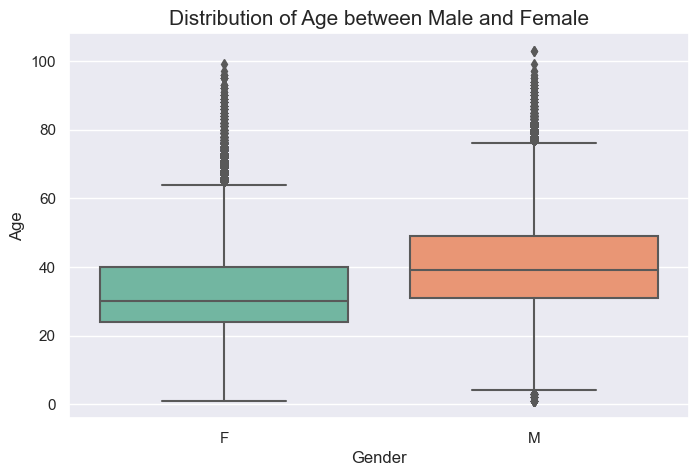

In [77]:
plt.figure(figsize=(8, 5))

sns.boxplot(x='Gender', y='Age', data=cmu)
plt.title('Distribution of Age between Male and Female', fontsize=15)

plt.xlabel('Gender', fontsize=12)
plt.ylabel('Age', fontsize=12)

plt.show()

In [78]:
# T-test to determine if the difference in age between men and women is statistically significant 
stats.ttest_ind(women_cmu_geo['Age'], men_cmu_geo['Age'], nan_policy='omit')

TtestResult(statistic=-128.55747337920405, pvalue=0.0, df=245153.0)

We used a two-sided t-test for the null hypothesis that the age of actors and actresses have identical average (expected) values. The p-value is much smaller than 0.05, therefore we can reject the null hypothesis, meaning that there is a statistically significant difference in the average ages between the two groups. As the t-statistic is strongly negative (-104), it supports our conclusion that women are significantly younger than men.

### Has this tendency evolved with years ?

First, we check that we have at least 100 ages per year in the women and men datasets.

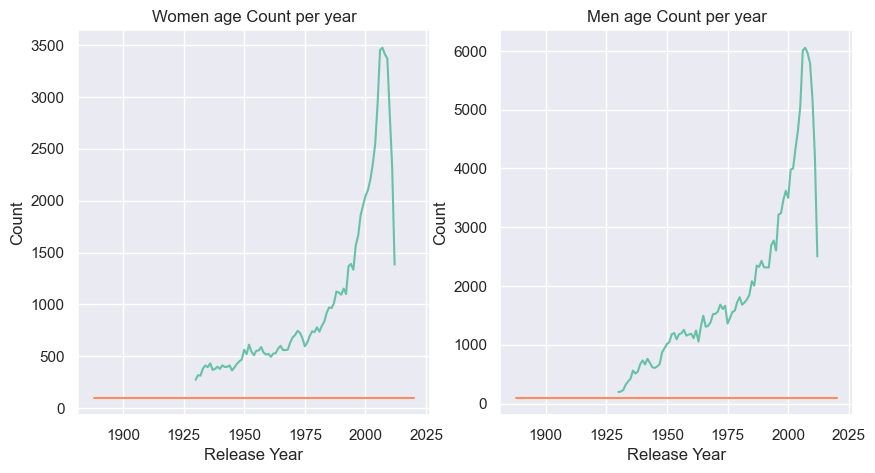

In [79]:
#Do we have enough information per year?
women_count_age_per_year_geo = women_cmu_geo.groupby('ReleaseYear').agg({'Age': 'count'})
men_count_age_per_year_geo = men_cmu_geo.groupby('ReleaseYear').agg({'Age': 'count'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize= (10,5))
ax1.plot(women_count_age_per_year_geo)
ax1.plot([1888, 2020], [100, 100])
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Count')
ax1.set_title('Women age Count per year')

ax2.plot(men_count_age_per_year_geo)
ax2.plot([1888, 2020], [100, 100])
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Count')
ax2.set_title('Men age Count per year')

plt.show()

In [80]:
display(men_count_age_per_year_geo)

,Age
ReleaseYear,
1930.0,198
1931.0,205
1932.0,232
1933.0,322
1934.0,378
...,...
2008.0,5961
2009.0,5791
2010.0,5182


For the men we don't have enough data before 1928; thus we will do the analysis with movies released after 1927.

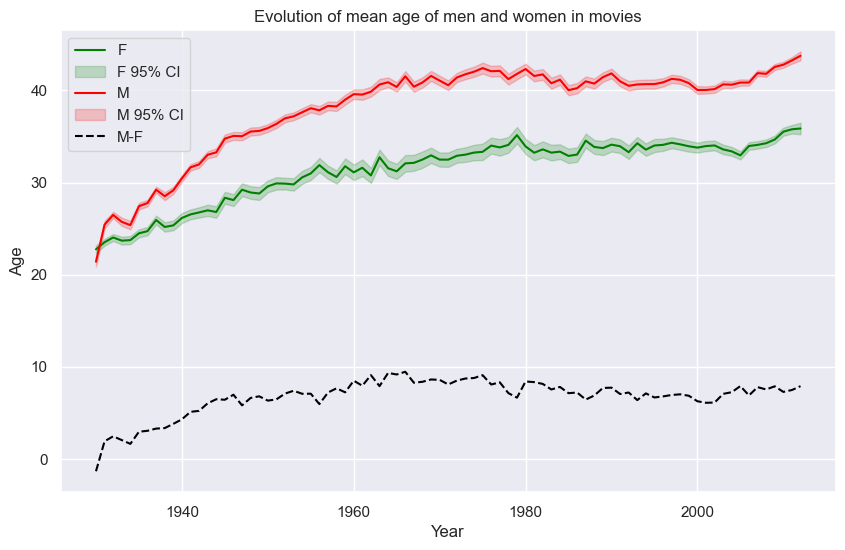

In [81]:
# Calculate the average age of actors and actresses in movies across year
women_mean_age_per_year_geo = women_cmu_geo.groupby('ReleaseYear').agg({'Age': 'mean'})
men_mean_age_per_year_geo = men_cmu_geo.groupby('ReleaseYear').agg({'Age': 'mean'})

# Calculate the 95% CIs
women_std_age_per_year_geo = women_cmu_geo.groupby('ReleaseYear').agg({'Age': 'std'})
men_std_age_per_year_geo = men_cmu_geo.groupby('ReleaseYear').agg({'Age': 'std'})

z=1.96
upper_bound_women_geo = women_mean_age_per_year_geo['Age'] + z*women_std_age_per_year_geo['Age']/np.sqrt(women_cmu_geo.groupby('ReleaseYear').agg({'Gender' : 'count'})['Gender'])
lower_bound_women_geo = women_mean_age_per_year_geo['Age'] - z*women_std_age_per_year_geo['Age']/np.sqrt(women_cmu_geo.groupby('ReleaseYear').agg({'Gender' : 'count'})['Gender'])

upper_bound_men_geo = men_mean_age_per_year_geo['Age'] + z*men_std_age_per_year_geo['Age']/np.sqrt(men_cmu_geo.groupby('ReleaseYear').agg({'Gender' : 'count'})['Gender'])
lower_bound_men_geo = men_mean_age_per_year_geo['Age'] - z*men_std_age_per_year_geo['Age']/np.sqrt(men_cmu_geo.groupby('ReleaseYear').agg({'Gender' : 'count'})['Gender'])

# Plot the evolution of mean age of men and women in movies
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(women_mean_age_per_year_geo[1928:], label='F', color='green')
ax.fill_between(women_mean_age_per_year_geo[1928:].index, lower_bound_women_geo[1928:], upper_bound_women_geo[1928:], alpha =0.2, color='green', label = 'F 95% CI')

ax.plot(men_mean_age_per_year_geo[1928:], label='M', color='red')
ax.fill_between(men_mean_age_per_year_geo[1928:].index, lower_bound_men_geo[1928:], upper_bound_men_geo[1928:], alpha =0.2, color='red', label = 'M 95% CI')

# (AR): Est-ce que vous pensez que c'est utile d'ajouter la différence entre les 2 ?
ax.plot(men_mean_age_per_year_geo[1928:]-women_mean_age_per_year_geo[1928:], label='M-F', color='k', linestyle='--')

#ax.set_ylim(10,47)
ax.set_xlabel('Year')
ax.set_ylabel('Age')
ax.set_title('Evolution of mean age of men and women in movies')
ax.legend()

plt.show()

### PROPORTION OF FEMALE CHARACTERS

We will explore the proportion of female characters in movies. Therefore, we first create a new dataframe containing the number and percentage of men and women per movie and the release year of the movie.

Now we can compare the distributions of the percentages of female and male characters per movie.

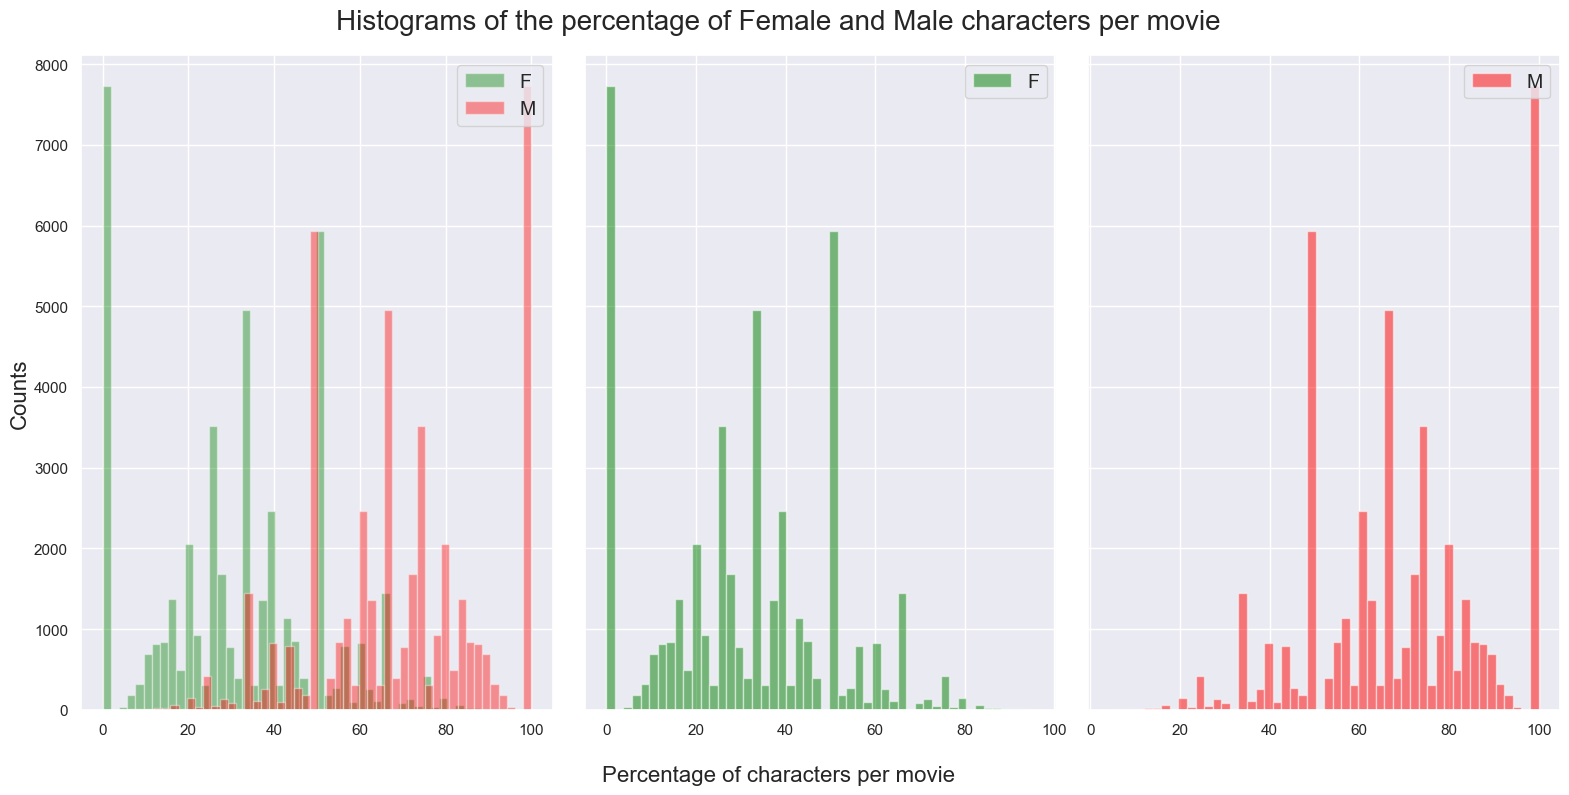

In [82]:
#Plot
fig, ax = plt.subplots(1, 3, figsize=(16,8), sharey=True)

ax[0].hist(df_gender_proportion_by_movie_geo['PercentageofFemale'], bins=50, label='F', alpha=0.4, color='green')
ax[0].hist(df_gender_proportion_by_movie_geo['PercentageofMale'], bins=50, label='M', alpha=0.4, color='red')
ax[0].legend(loc='upper right', fontsize=14) 

ax[1].hist(df_gender_proportion_by_movie_geo['PercentageofFemale'], bins=50, label='F', alpha=0.5, color='green')
ax[1].legend(loc='upper right', fontsize=14) 

ax[2].hist(df_gender_proportion_by_movie_geo['PercentageofMale'], bins=50, label='M', alpha=0.5, color='red')
ax[2].legend(loc='upper right', fontsize=14) 

fig.supxlabel('Percentage of characters per movie', fontsize=16)
fig.supylabel('Counts', va='center', rotation=90, fontsize=16)
fig.suptitle('Histograms of the percentage of Female and Male characters per movie', fontsize=20)

plt.tight_layout()

plt.show()

We can see that the female distirbution is centered around values inferior to 50%, while the men distribution is centered around values superior to 50%.
We can test if the difference of mean percentage is significantly different at the 0.05 level.

In [83]:
# T-test to determine if the difference between the percentage of male and female character per movie is statistically significant. 
stats.ttest_ind(df_gender_proportion_by_movie_geo['PercentageofFemale'], df_gender_proportion_by_movie_geo['PercentageofMale'], nan_policy='omit')

TtestResult(statistic=-292.191991086202, pvalue=0.0, df=89552.0)

The p-value is smaller than 0.05, therefore the difference is statistically significant; the value of the t-test indicates that there are significantly less female than male characters per movie.

Is this tendency constant across years?

The confidence intervals don't overlap: across years, there is always a significantly smaller percentage of female than male characters per movie.

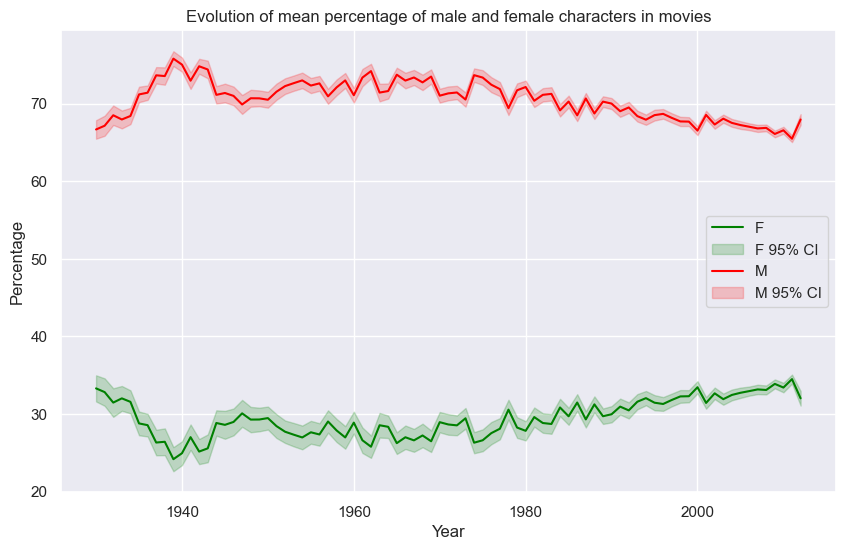

In [84]:
#Calculate the mean percentage of actors and actresses in movies across year
percentage_of_women_by_movie_geo = df_gender_proportion_by_movie_geo.groupby('ReleaseYear').agg({'PercentageofFemale':'mean'})
percentage_of_men_by_movie_geo = df_gender_proportion_by_movie_geo.groupby('ReleaseYear').agg({'PercentageofMale':'mean'})

#Calculate the 95% CIs
women_std_perc_per_year_geo = df_gender_proportion_by_movie_geo.groupby('ReleaseYear').agg({'PercentageofFemale':'std'})
men_std_perc_per_year_geo = df_gender_proportion_by_movie_geo.groupby('ReleaseYear').agg({'PercentageofMale':'std'})

z=1.96
upper_bound_women_geo = percentage_of_women_by_movie_geo['PercentageofFemale'] + z*women_std_perc_per_year_geo['PercentageofFemale']/np.sqrt(women_cmu_geo.groupby('ReleaseYear').agg({'Gender': 'count'})['Gender'])
lower_bound_women_geo = percentage_of_women_by_movie_geo['PercentageofFemale'] - z*women_std_perc_per_year_geo['PercentageofFemale']/np.sqrt(women_cmu_geo.groupby('ReleaseYear').agg({'Gender': 'count'})['Gender'])

upper_bound_men_geo = percentage_of_men_by_movie_geo['PercentageofMale'] + z*men_std_perc_per_year_geo['PercentageofMale']/np.sqrt(men_cmu_geo.groupby('ReleaseYear').agg({'Gender': 'count'})['Gender'])
lower_bound_men_geo = percentage_of_men_by_movie_geo['PercentageofMale'] - z*men_std_perc_per_year_geo['PercentageofMale']/np.sqrt(men_cmu_geo.groupby('ReleaseYear').agg({'Gender': 'count'})['Gender'])

#Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(percentage_of_women_by_movie_geo, label='F', color='green')
ax.fill_between(lower_bound_women_geo.index, lower_bound_women_geo, upper_bound_women_geo, alpha =0.2, color='green', label = 'F 95% CI')

ax.plot(percentage_of_men_by_movie_geo, label='M', color='red')
ax.fill_between(lower_bound_men_geo.index, lower_bound_men_geo, upper_bound_men_geo, alpha =0.2, color='red', label = 'M 95% CI')

#ax.set_ylim(0,101)
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('Evolution of mean percentage of male and female characters in movies')
ax.legend()
plt.show()

### GENRE OF MOVIE: IS THERE A DIFFERENCE ?

An often-repeated stereotype regarding women suggests that they are not inclined towards action, sports, or intellectual pursuits, but rather, their primary role is portrayed as being centered around romantic relationships. We aim to investigate whether this stereotype is reflected in the portrayal of women in movies from our dataset.

We will do our analysis only based on the 16 major genres of movie in the dataset. First, we need to determine what these 16 genres are.

In [85]:
# Filter the cmu dataset to get only 1 row per movie. Otherwise, the genres are counted too many times
cmu_without_duplicates = cmu.drop_duplicates(subset=['WikiMovieID'], keep='first')

In [86]:
display(cmu_without_duplicates)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,CharacterName,Gender,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01jfsb': 'Thriller'},2001.0,Akooshay,F,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
17,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'},2000.0,Police Officer,M,NaN,Allen Cutler,NaN,/m/0lr37fl,/m/0lr3z80,/m/0h8pnlw
32,28463795,/m/0crgdbh,Brun bitter,1988,NaN,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},{'/m/0lsxr': 'Crime Fiction'},1988.0,NaN,M,NaN,Frank Krog,33.0,/m/0gct1bn,NaN,/m/053j7xf
36,9363483,/m/0285_cd,White Of The Eye,1987,NaN,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/01jfsb': 'Thriller'},1987.0,NaN,M,NaN,David Keith,32.0,/m/02t9_0c,NaN,/m/036496
38,261236,/m/01mrr1,A Woman in Flames,1983,NaN,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},1983.0,NaN,F,NaN,Gudrun Landgrebe,32.0,/m/02vb3cv,NaN,/m/09d6hv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401020,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/0lsxr': 'Crime Fiction'},1941.0,NaN,F,NaN,Kathleen Harrison,NaN,/m/0cf_nn2,NaN,/m/04d7mh
401031,32468537,/m/0crwd9y,Shadow Boxing 2,2007-10-18,NaN,"{'/m/06b_j': 'Russian Language', '/m/02h40lc':...",{'/m/06bnz': 'Russia'},{'/m/0lsxr': 'Crime Fiction'},2007.0,NaN,M,NaN,Andrei Panin,45.0,/m/0h1ks15,NaN,/m/03nnxgl
401038,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/01z4y': 'Comedy'},1972.0,NaN,M,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5
401040,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},{'/m/03k9fj': 'Adventure'},1992.0,Mesena,M,NaN,Isshin Chiba,23.0,/m/0kr40bw,/m/0kr40b_,/m/04xwsh


In [87]:
## DEJA EN HAUT DANS PREPROSSESSING
all_unique_genres = set()

# Get all the movie genres
cmu_without_duplicates['MovieGenre'].apply(lambda x: all_unique_genres.update(x.values()) if isinstance(x, dict) else None)

# Initialize dictionary with keys and values set to 0
genres_count = {genre: 0 for genre in all_unique_genres}

# Count the occurence of each genre
for row in cmu_without_duplicates['MovieGenre']:
    for key, value in row.items():
        genres_count[value]+=1
        
# Sort the dictionary by values in descending order
genres_count = dict(sorted(genres_count.items(), key=lambda item: item[1], reverse=True))

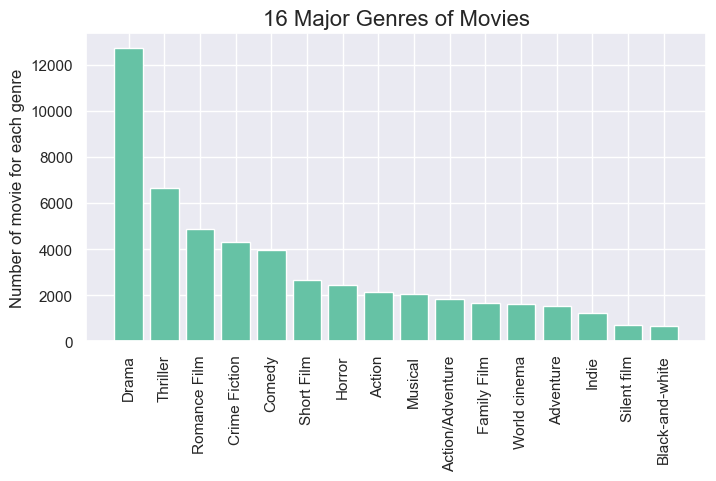

In [88]:
## DEJA EN HAUT DANS PREPROSSESSING

plt.figure(figsize=(8, 4))

# Keep the first 16 major genres
major_16_genres = dict(islice(genres_count.items(), 16))

x = np.arange(len(major_16_genres))

plt.bar(x, major_16_genres.values())
plt.xticks(x, major_16_genres.keys(), rotation='vertical')
plt.title('16 Major Genres of Movies', fontsize=16)
plt.ylabel('Number of movie for each genre')
plt.show()

For the analysis we consider that:
- If a movie has several genres, we will keep the one that appears in the 16 major genres, and if several are in the 16 major genres, we keep the first one.
- If none is in the 16 major genre, or if the genre is not given, then we drop the row

In [89]:
# Merge cmu and df_gender_proportion_by_movie to have the proportion of make and female in cmu

In [90]:
# List of rows to drop 
rows_to_drop = []

cmu_16_genre = cmu.copy()

for index, row in cmu_16_genre.iterrows():
    movie_genre = row['MovieGenre']
    
    # If there is one genre only, drop the row if not in the 16 major genre
    if len(movie_genre) == 1 and list(movie_genre.values())[0] not in major_16_genres:
        rows_to_drop.append(index)
        
    #If there is no genre, drop the corresponding row
    elif not bool(movie_genre):
        print('here')
    #    rows_to_drop.append(index)
            
    # If there are multiple genres        
    #else:
    #    count = 0  # To keep the first value only
    #    for key, value in movie_genre.items():
    #        if value in major_16_genres:
    #            if count == 0:
    #                value_to_keep = value
    #                key_to_keep = key
    #                count = 1
    #                break
    #
    #    if count == 0:  # If none of the genres is in the major_16_genres, drop the row
    #        rows_to_drop.append(index)

     #   if count == 1:
     #       movies_16_genre.at[index, 'MovieGenre'] = {key_to_keep: value_to_keep}

# Modify cmu_16_genre to keep only movies that are in the 16 major genres
cmu_16_genre = cmu_16_genre.drop(rows_to_drop)
movie_counts = cmu_16_genre['WikiMovieID'].nunique()
print(f'We are left with {movie_counts} movies')

We are left with 51183 movies


To facilitate analysis, we replace the dictionary for the 'MovieGenre' column with a str:

In [91]:
cmu_16_genre['MovieGenre'].isna().value_counts()

MovieGenre
False    362414
Name: count, dtype: int64

In [92]:
cmu_16_genre['MovieGenre'] = cmu_16_genre['MovieGenre'].apply(lambda x: list(x.values())[0])

In [94]:
cmu_16_genre = pd.merge(cmu_16_genre, df_gender_proportion_by_movie_geo, on = ['WikiMovieID', 'ReleaseYear'], how = 'left')

In [ ]:
# Split the dataset in 2 according to actor gender
#women_with_genre = cmu_genre.loc[cmu_genre['Gender']=='F'].copy(deep=True)
#men_with_genre = cmu_genre.loc[cmu_genre['Gender']=='M'].copy(deep=True)

In [ ]:
# Group by 'MovieGenre' and count the number of occurence
#women_genre_counts = women_with_genre.groupby('MovieGenre').size().reset_index(name='Women_Count')
#men_genre_counts = men_with_genre.groupby('MovieGenre').size().reset_index(name='Men_Count')

# New dataframe with the counts
#genre_counts = women_genre_counts.merge(men_genre_counts, how='left', on='MovieGenre')

# Compute the percentage of Women and Men per movie genre
#genre_counts['Percent_Women']=(genre_counts['Women_Count']/(genre_counts['Women_Count']+genre_counts['Men_Count']))*100
#genre_counts['Percent_Men']=(genre_counts['Men_Count']/(genre_counts['Women_Count']+genre_counts['Men_Count']))*100

In [ ]:
#genre_counts.sample(2)

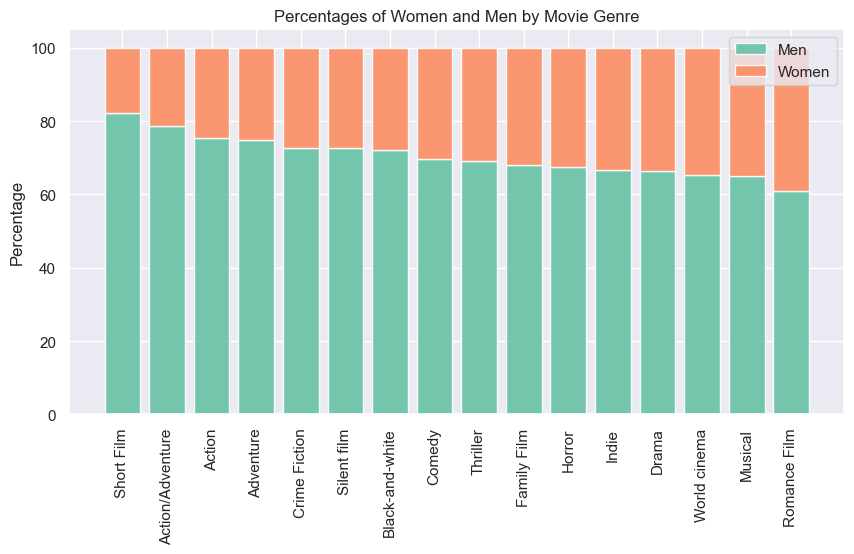

In [95]:
# Plot the percentage of Women and Men per movie genre

# Filter the cmu dataset to get only 1 row per movie. Otherwise, the genres are counted too many times
cmu_16_without_duplicates = cmu_16_genre.drop_duplicates(subset=['WikiMovieID'], keep='first')

women_perc_by_genre = cmu_16_without_duplicates.groupby('MovieGenre').agg({'PercentageofFemale': 'mean'})
men_perc_by_genre = cmu_16_without_duplicates.groupby('MovieGenre').agg({'PercentageofMale': 'mean'})


# Sort the DataFrame for better visualization
women_perc_by_genre = women_perc_by_genre.sort_values(by='PercentageofFemale', ascending=True)
men_perc_by_genre = men_perc_by_genre.sort_values(by='PercentageofMale', ascending=False)


fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(men_perc_by_genre.index, men_perc_by_genre['PercentageofMale'], label='Men', alpha=0.9)
ax.bar(women_perc_by_genre.index, women_perc_by_genre['PercentageofFemale'], bottom=men_perc_by_genre['PercentageofMale'], label='Women', alpha=0.9)

plt.xticks(rotation='vertical')
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Women and Men by Movie Genre')
ax.legend()

plt.show()

Is there a difference in actors' ages between genres? 

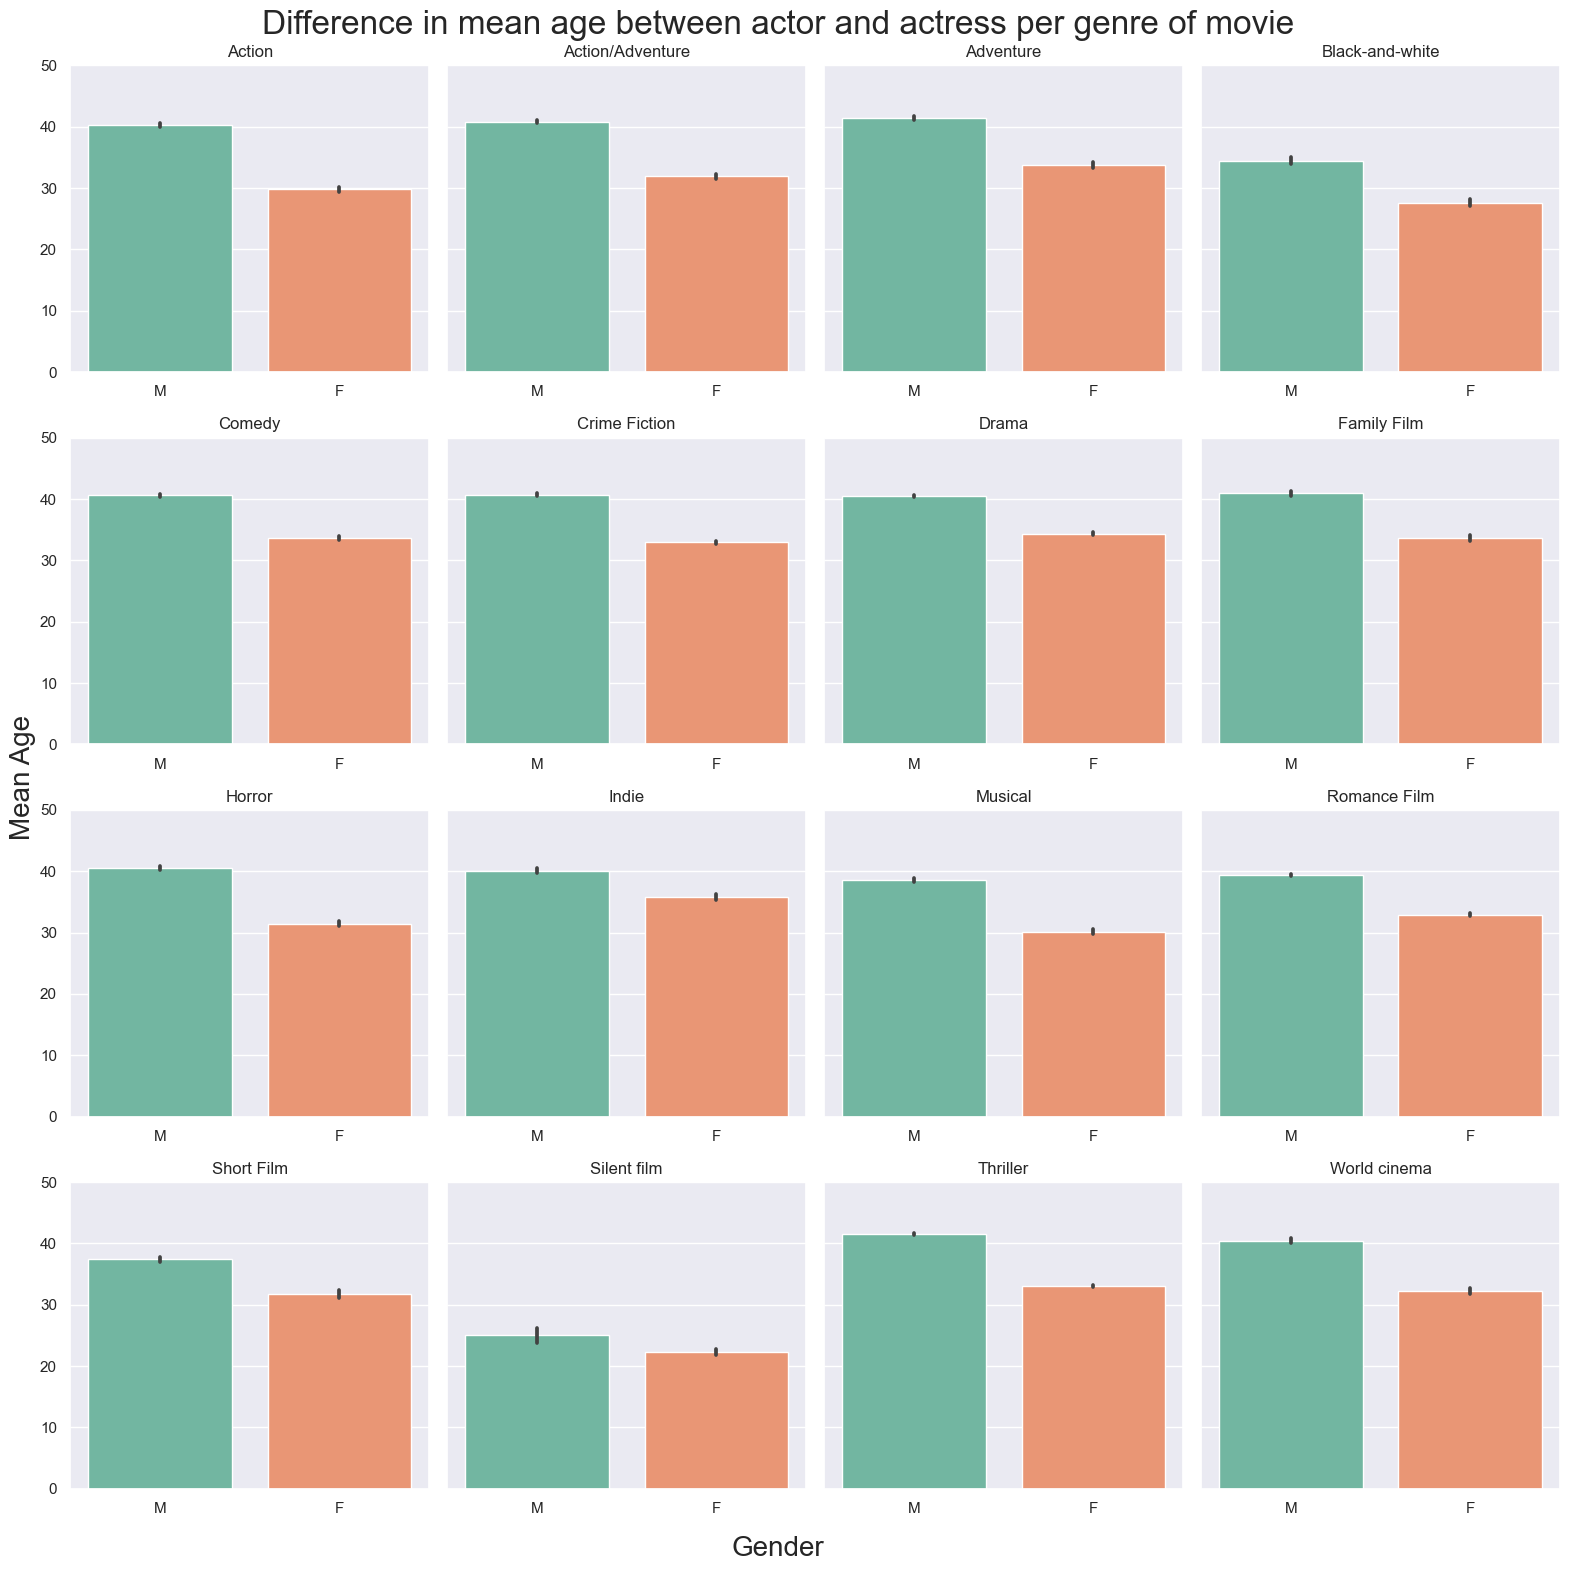

In [96]:
cmu_by_genre = cmu_16_genre.groupby('MovieGenre')

fig, axes = plt.subplots(4,4,figsize= (16,16), sharey=True)

for genre, ax in zip(cmu_by_genre.groups.keys(), axes.flat):
    sns.set(style="darkgrid", palette="Set2")
    
    plot = sns.barplot(x='Gender', y='Age', data=cmu_by_genre.get_group(genre), ax=ax, order=['M', 'F'], errorbar=('ci',95))
    plot.set_title(genre)
    plot.set(ylabel=None)
    plot.set(xlabel=None)
    plot.set(ylim = (0,50))

fig.supxlabel('Gender', fontsize=20)
fig.supylabel('Mean Age', va='center', rotation=90, fontsize=20)
fig.suptitle('Difference in mean age between actor and actress per genre of movie', fontsize=24)

plt.tight_layout()

plt.show()

Across all genres we observe a similar inequality in the average age of actors and actresses. Actresses are generally younger in all movie genres and the difference is significant when looking at the small 95 % confidence intervals

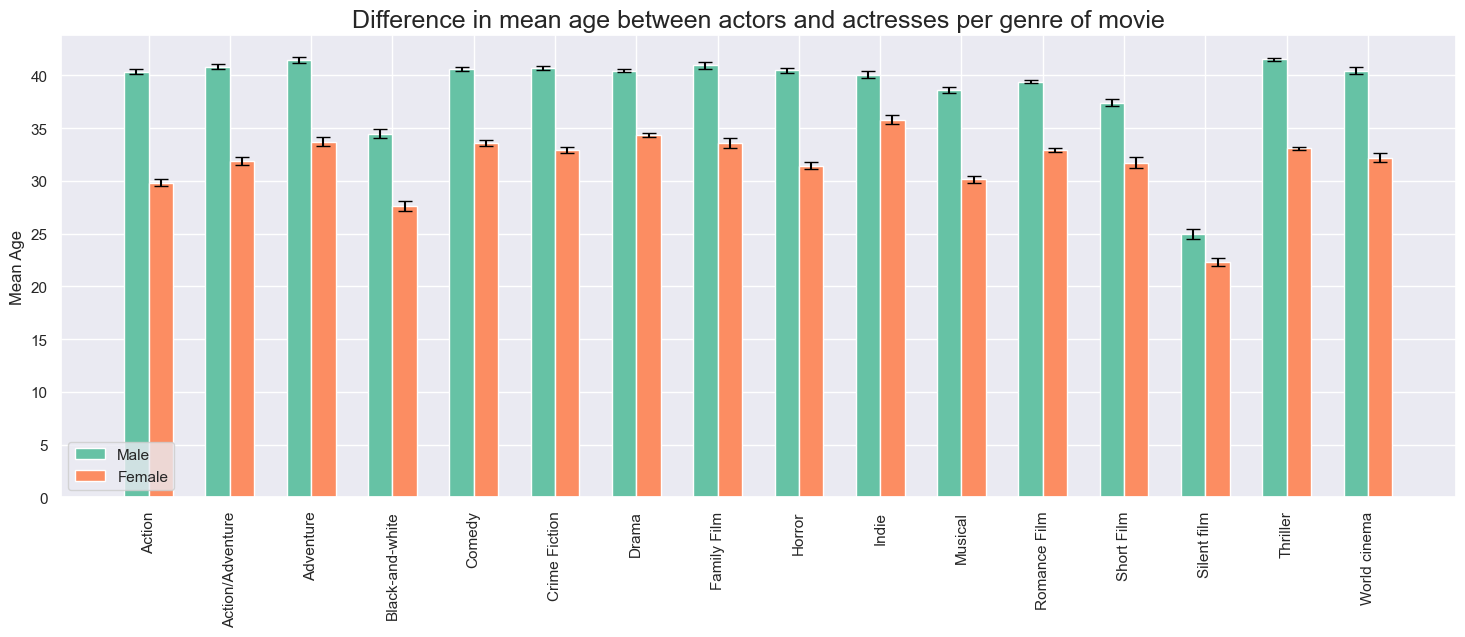

In [97]:
#(AR): Autre proposition pour le plot, au lieu d'avoir 16 subplots

cmu_by_genre = cmu_16_genre.groupby('MovieGenre')

N = len(cmu_by_genre.groups.keys()) # Number of main genre of movies
ind = np.arange(N)
width = 0.3

mean_ages_M, mean_ages_F, movie_genres = [], [], []
for genre in cmu_by_genre.groups.keys():
    # Compute the mean age for actor and actresses for each movie genre
    mean_age_M_genre = np.mean(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender']=='M']['Age'])
    mean_age_F_genre = np.mean(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender']=='F']['Age'])

    mean_ages_M.append(mean_age_M_genre)
    mean_ages_F.append(mean_age_F_genre)
    movie_genres.append(genre)

# Calculate the standard error of the mean for each movie genre
serr_ages_M = [np.std(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender'] == 'M']['Age']) /
              np.sqrt(len(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender'] == 'M'])) for genre in cmu_by_genre.groups.keys()]

serr_ages_F = [np.std(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender'] == 'F']['Age']) /
              np.sqrt(len(cmu_by_genre.get_group(genre)[cmu_by_genre.get_group(genre)['Gender'] == 'F'])) for genre in cmu_by_genre.groups.keys()]

plt.figure(figsize=(18,6))

plt.bar(ind, mean_ages_M , width, label='Male', yerr=1.96*np.array(serr_ages_M), capsize=5)
plt.bar(ind + width, mean_ages_F, width, label='Female', yerr=1.96*np.array(serr_ages_F), capsize=5)

plt.ylabel('Mean Age')
plt.title('Difference in mean age between actors and actresses per genre of movie', fontsize=18)
plt.xticks(ind + width / 2, movie_genres, rotation=90)
plt.legend(loc='best')

plt.show()

### SENTIMENT ANALYSIS

#### Gender of the main character vs plot summary sentiment

Let's delve into the relationship between the gender of the main character and the overall sentiment of a movie: Does a film centered around a female protagonist evoke a distinct sentiment compared to one led by a male protagonist? If so, does this difference tend towards a more or less positive portrayal?

In [98]:
#Get the main character and its gender, the production coutry and the release year
plot_summaries_main_char = pd.merge(plot_summaries, cmu_geo[['WikiMovieID', 'MovieName', 'ActorName', 'ReleaseYear', 'MovieGenre', 'Countries']], on = 'WikiMovieID', how='inner')
plot_summaries_main_char = pd.merge(plot_summaries_main_char, credits[['title', 'main_char_gender', 'main_actor']], left_on = ['MovieName', 'ActorName'], right_on = ['title', 'main_actor'], how='inner')
plot_summaries_main_char = plot_summaries_main_char.drop('title', axis=1)
display(plot_summaries_main_char)

,WikiMovieID,Summary,Sentiment,MovieName,ActorName,ReleaseYear,MovieGenre,Countries,main_char_gender,main_actor
0,31186339,"(The, nation, of, Panem, consists, of, a, weal...",0.045261,The Hunger Games,Jennifer Lawrence,2012.0,{'/m/03btsm8': 'Action/Adventure'},US,F,Jennifer Lawrence
1,1952976,"({, {, plot, }, }, The, film, opens, in, 1974,...",0.025839,Dark Water,Jennifer Connelly,2005.0,{'/m/01jfsb': 'Thriller'},US,F,Jennifer Connelly
2,2462689,"(Infuriated, at, being, told, to, write, one, ...",0.037964,Meet John Doe,Barbara Stanwyck,1941.0,{'/m/01g6gs': 'Black-and-white'},US,F,Barbara Stanwyck
3,1335380,"(The, film, is, based, on, the, events, that, ...",0.026543,Exodus,Paul Newman,1960.0,{'/m/03btsm8': 'Action/Adventure'},US,M,Paul Newman
4,1480747,"({, {, plot, }, }, Following, the, sudden, dea...",0.070732,House Party 2,Martin Lawrence,1991.0,{'/m/01z4y': 'Comedy'},US,M,Martin Lawrence
...,...,...,...,...,...,...,...,...,...,...
12227,27978238,"(In, 1864, ,, Union, army, officer, Capt, ., J...",-0.071930,Westbound,Randolph Scott,1959.0,{'/m/0hfjk': 'Western'},US,M,Randolph Scott
12228,4913923,"(In, Northern, Norway, during, the, 1860s, ,, ...",-0.000852,I Am Dina,Maria Bonnevie,2002.0,{'/m/07s9rl0': 'Drama'},FR,F,Maria Bonnevie
12229,26261438,"(While, drinking, alone, one, night, and, remi...",0.022576,Outlaw of Gor,Jack Palance,1989.0,{'/m/03k9fj': 'Adventure'},US,M,Jack Palance
12230,17208834,"(A, high, school, prom, in, Georgia, is, unexp...",-0.048327,Dance of the Dead,Jared Kusnitz,2008.0,{'/m/03npn': 'Horror'},US,M,Jared Kusnitz


In [99]:
#Duplicates can appear if an actor had several roles in the same movie. Then we drop the duplicated rows.
plot_summaries_main_char = plot_summaries_main_char.drop_duplicates(subset='WikiMovieID')
display(plot_summaries_main_char)

,WikiMovieID,Summary,Sentiment,MovieName,ActorName,ReleaseYear,MovieGenre,Countries,main_char_gender,main_actor
0,31186339,"(The, nation, of, Panem, consists, of, a, weal...",0.045261,The Hunger Games,Jennifer Lawrence,2012.0,{'/m/03btsm8': 'Action/Adventure'},US,F,Jennifer Lawrence
1,1952976,"({, {, plot, }, }, The, film, opens, in, 1974,...",0.025839,Dark Water,Jennifer Connelly,2005.0,{'/m/01jfsb': 'Thriller'},US,F,Jennifer Connelly
2,2462689,"(Infuriated, at, being, told, to, write, one, ...",0.037964,Meet John Doe,Barbara Stanwyck,1941.0,{'/m/01g6gs': 'Black-and-white'},US,F,Barbara Stanwyck
3,1335380,"(The, film, is, based, on, the, events, that, ...",0.026543,Exodus,Paul Newman,1960.0,{'/m/03btsm8': 'Action/Adventure'},US,M,Paul Newman
4,1480747,"({, {, plot, }, }, Following, the, sudden, dea...",0.070732,House Party 2,Martin Lawrence,1991.0,{'/m/01z4y': 'Comedy'},US,M,Martin Lawrence
...,...,...,...,...,...,...,...,...,...,...
12227,27978238,"(In, 1864, ,, Union, army, officer, Capt, ., J...",-0.071930,Westbound,Randolph Scott,1959.0,{'/m/0hfjk': 'Western'},US,M,Randolph Scott
12228,4913923,"(In, Northern, Norway, during, the, 1860s, ,, ...",-0.000852,I Am Dina,Maria Bonnevie,2002.0,{'/m/07s9rl0': 'Drama'},FR,F,Maria Bonnevie
12229,26261438,"(While, drinking, alone, one, night, and, remi...",0.022576,Outlaw of Gor,Jack Palance,1989.0,{'/m/03k9fj': 'Adventure'},US,M,Jack Palance
12230,17208834,"(A, high, school, prom, in, Georgia, is, unexp...",-0.048327,Dance of the Dead,Jared Kusnitz,2008.0,{'/m/03npn': 'Horror'},US,M,Jared Kusnitz


In [100]:
plot_summaries_main_char=plot_summaries_main_char.drop(['main_actor'], axis=1)
display(plot_summaries_main_char)

,WikiMovieID,Summary,Sentiment,MovieName,ActorName,ReleaseYear,MovieGenre,Countries,main_char_gender
0,31186339,"(The, nation, of, Panem, consists, of, a, weal...",0.045261,The Hunger Games,Jennifer Lawrence,2012.0,{'/m/03btsm8': 'Action/Adventure'},US,F
1,1952976,"({, {, plot, }, }, The, film, opens, in, 1974,...",0.025839,Dark Water,Jennifer Connelly,2005.0,{'/m/01jfsb': 'Thriller'},US,F
2,2462689,"(Infuriated, at, being, told, to, write, one, ...",0.037964,Meet John Doe,Barbara Stanwyck,1941.0,{'/m/01g6gs': 'Black-and-white'},US,F
3,1335380,"(The, film, is, based, on, the, events, that, ...",0.026543,Exodus,Paul Newman,1960.0,{'/m/03btsm8': 'Action/Adventure'},US,M
4,1480747,"({, {, plot, }, }, Following, the, sudden, dea...",0.070732,House Party 2,Martin Lawrence,1991.0,{'/m/01z4y': 'Comedy'},US,M
...,...,...,...,...,...,...,...,...,...
12227,27978238,"(In, 1864, ,, Union, army, officer, Capt, ., J...",-0.071930,Westbound,Randolph Scott,1959.0,{'/m/0hfjk': 'Western'},US,M
12228,4913923,"(In, Northern, Norway, during, the, 1860s, ,, ...",-0.000852,I Am Dina,Maria Bonnevie,2002.0,{'/m/07s9rl0': 'Drama'},FR,F
12229,26261438,"(While, drinking, alone, one, night, and, remi...",0.022576,Outlaw of Gor,Jack Palance,1989.0,{'/m/03k9fj': 'Adventure'},US,M
12230,17208834,"(A, high, school, prom, in, Georgia, is, unexp...",-0.048327,Dance of the Dead,Jared Kusnitz,2008.0,{'/m/03npn': 'Horror'},US,M


##### Matching

To conduct a causal analysis, we begin by constructing pairs of movies wherein the main character's gender is the differing factor. This entails matching films precisely in terms of their genre, production country, and release period.

By creating these matched pairs, we aim to isolate the influence of the main character's gender while holding constant other significant variables such as genre (e.g., action, drama, comedy), production country (e.g., USA, France, Japan), and release period (e.g., 5-years window). This method allows us to scrutinize whether any observed differences in sentiment can be attributed primarily to the main character's gender rather than other contextual factors.

In [105]:
# Create bins for every 5 years starting from the minimum release year to the maximum release year
min_year = int(plot_summaries_main_char['ReleaseYear'].min())
max_year = int(plot_summaries_main_char['ReleaseYear'].max())
bins = list(range(min_year, max_year + 6, 5))  # Adding 6 to include the upper bound

# Create labels for the bins
labels = [f'{start}-{start+4}' for start in bins[:-1]]

# Use pd.cut to categorize release years into bins
plot_summaries_main_char['ReleaseYearBin'] = pd.cut(plot_summaries_main_char['ReleaseYear'], bins=bins, labels=labels, include_lowest=True)

In [107]:
#Separate the dataframe depending on the main character's gender
plot_summaries_main_char_M = plot_summaries_main_char[plot_summaries_main_char['main_char_gender'] == 'M']
plot_summaries_main_char_F = plot_summaries_main_char[plot_summaries_main_char['main_char_gender'] == 'F']

In [110]:
#Match exactly on the movie genre, production country and release-year window
exact_match_columns = ['ReleaseYearBin', 'MovieGenre', 'Countries']

# Create an empty undirected graph
G_sentiment = nx.Graph()

i = 0
# Loop through all the pairs of instances
for main_char_M_id, main_char_M_row in plot_summaries_main_char_M.iterrows():
    i = i+1
    print(f'Row {i} out of 8611')
    for main_char_F_id, main_char_F_row in plot_summaries_main_char_F.iterrows():
        
        # Add an edge between the two instances if same track and same score before
        if exact_match(exact_match_columns,  main_char_M_row, main_char_F_row):
            G_sentiment.add_edge(main_char_M_id, main_char_F_id)

print('loop finished')
# Generate and return the maximum weight matching on the generated graph
pair_summaries = nx.maximal_matching(G_sentiment)
print('The number of matching pairs is:', len(pair_summaries))

Row 1 out of 8611
Row 2 out of 8611
Row 3 out of 8611
Row 4 out of 8611
Row 5 out of 8611
Row 6 out of 8611
Row 7 out of 8611
Row 8 out of 8611
Row 9 out of 8611
Row 10 out of 8611
Row 11 out of 8611
Row 12 out of 8611
Row 13 out of 8611
Row 14 out of 8611
Row 15 out of 8611
Row 16 out of 8611
Row 17 out of 8611
Row 18 out of 8611
Row 19 out of 8611
Row 20 out of 8611
Row 21 out of 8611
Row 22 out of 8611
Row 23 out of 8611
Row 24 out of 8611
Row 25 out of 8611
Row 26 out of 8611
Row 27 out of 8611
Row 28 out of 8611
Row 29 out of 8611
Row 30 out of 8611
Row 31 out of 8611
Row 32 out of 8611
Row 33 out of 8611
Row 34 out of 8611
Row 35 out of 8611
Row 36 out of 8611
Row 37 out of 8611
Row 38 out of 8611
Row 39 out of 8611
Row 40 out of 8611
Row 41 out of 8611
Row 42 out of 8611
Row 43 out of 8611
Row 44 out of 8611
Row 45 out of 8611
Row 46 out of 8611
Row 47 out of 8611
Row 48 out of 8611
Row 49 out of 8611
Row 50 out of 8611
Row 51 out of 8611
Row 52 out of 8611
Row 53 out of 8611
Ro

In [111]:
#Retrieve the movies and create a new balanced dataframe
balanced_summaries_main_char_ids = [i[0] for i in list(pair_summaries)]+ [i[1] for i in list(pair_summaries)] 
balanced_summaries_main_char = plot_summaries_main_char.loc[balanced_summaries_main_char_ids]

##### Linear regression analysis

In [112]:
#One-hot encode the main character's gender
balanced_summaries_main_char = pd.get_dummies(balanced_summaries_main_char, columns =['main_char_gender'], prefix = '',prefix_sep='', dtype= int)
balanced_summaries_main_char.rename(columns={'F': 'MainCharFemale', 'M': 'MainCharMale'}, inplace=True)
display(balanced_summaries_main_char)

,WikiMovieID,Summary,Sentiment,MovieName,ActorName,ReleaseYear,MovieGenre,Countries,ReleaseYearBin,MainCharFemale,MainCharMale
6118,25452154,"(Cynical, ad, executive, B., D., Tucker, , is...",-0.250000,Beer,Loretta Swit,1985.0,{'/m/01z4y': 'Comedy'},US,1980-1984,1,0
10562,80488,"({, {, quote, }, }, The, film, opens, with, Sh...",-0.019334,Spellbound,Ingrid Bergman,1945.0,{'/m/01jfsb': 'Thriller'},US,1940-1944,1,0
4485,918091,"(In, 1912, ,, Broadway, star, Don, Hewes, , i...",0.111606,Easter Parade,Judy Garland,1948.0,{'/m/04t36': 'Musical'},US,1945-1949,1,0
11531,2058829,"(The, movie, tells, the, story, of, a, family,...",0.100000,Clara's Heart,Whoopi Goldberg,1988.0,{'/m/07s9rl0': 'Drama'},US,1985-1989,1,0
6933,3146380,"(Birdee, Pruitt, , is, a, Chicago, housewife,...",0.051661,Hope Floats,Sandra Bullock,1998.0,{'/m/07s9rl0': 'Drama'},US,1995-1999,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5632,6647287,"(Entertainer, Bill, Miller, believes, that, he...",0.121838,The Stooge,Dean Martin,1952.0,{'/m/04t36': 'Musical'},US,1950-1954,0,1
6494,1285833,"(Brando, appears, at, the, start, of, the, fil...",-0.047059,The Men,Marlon Brando,1950.0,{'/m/02l7c8': 'Romance Film'},US,1945-1949,0,1
1520,4464025,"(Mr., Jones, , is, a, man, suffering, from, b...",0.100000,Mr. Jones,Richard Gere,1993.0,{'/m/02l7c8': 'Romance Film'},US,1990-1994,0,1
1476,20638510,"({, {, Quote, }, }, Christopher, ,, a, lonely,...",-0.035180,Murder Party,Alex Barnett,2007.0,{'/m/03npn': 'Horror'},US,2005-2009,0,1


In [114]:
#Linear regression
reg_model_sentiment = smf.ols(formula = 'Sentiment ~ MainCharFemale + MainCharMale', data = balanced_summaries_main_char)

results_sentiment = reg_model_sentiment.fit()
print(results_sentiment.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:              Sentiment   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     15.34
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           9.07e-05
Time:                        11:17:40   Log-Likelihood:                 4382.9
No. Observations:                5872   AIC:                            -8762.
Df Residuals:                    5870   BIC:                            -8748.
Df Model:                           1                                         
Covariance Type:            nonrobust  

In [115]:
#Test if the difference between the coefficients is significant

coeff_summary_F, coeff_summary_M = results_sentiment.params['MainCharFemale'],results_sentiment.params['MainCharMale']
std_e_summary_F, std_e_summary_M = results_sentiment.bse['MainCharFemale'],results_sentiment.bse['MainCharMale']

test_statistic = (coeff_summary_F - coeff_summary_M) / ((std_e_summary_F**2) + (std_e_summary_M**2))**0.5

#Two-tailed critical value for a 95% Confidence Interval
critical_value = 1.96

if abs(test_statistic) > critical_value:
    print('The difference between the coefficients is significant')
else : 
    print('The difference between the coefficients is not significant')

The difference between the coefficients is significant


## PART 2: Qualitative analysis of gender representation in movies <a id="part2.2"></a>

### What are the types of characters women interpret ? 

Let's uncover whether the common stereotypes about women align with the characters we observe on the screen.


For this analysis, we will use the tvtropes.clusters file

In [116]:
with open(CHARACTER_TYPE_PATH, 'r') as file:
    lines = file.readlines()
    new_lines = []
    
    for line in lines:
        char_type = line.split()[0]
        char_type_dict = {'CharType': char_type}

        space_index = line.find('	')
        char_info = ast.literal_eval(line[space_index+1:])
        
        new_line = {**char_type_dict, **char_info}
        
        new_lines.append(new_line)
    

# Evaluate each line and extract the column name and corresponding dictionary

headers_names = ['CharType',
                 'CharName',
                 'MovieName',
                 'FreebaseActorMapID',
                 'ActorName']

chartypes = pd.DataFrame(new_lines)
chartypes.columns = headers_names
chartypes.head()

,CharType,CharName,MovieName,FreebaseActorMapID,ActorName
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [117]:
chartype_cmu = cmu.merge(chartypes, how='right', on=['FreebaseActorMapID', 'MovieName'])
chartype_women = chartype_cmu.loc[chartype_cmu['Gender']=='F'].copy(deep=True)
chartype_men = chartype_cmu.loc[chartype_cmu['Gender']=='M'].copy(deep=True)

In [118]:
women_counts = chartype_women['CharType'].value_counts().head(5)
men_counts = chartype_men['CharType'].value_counts().head(5)

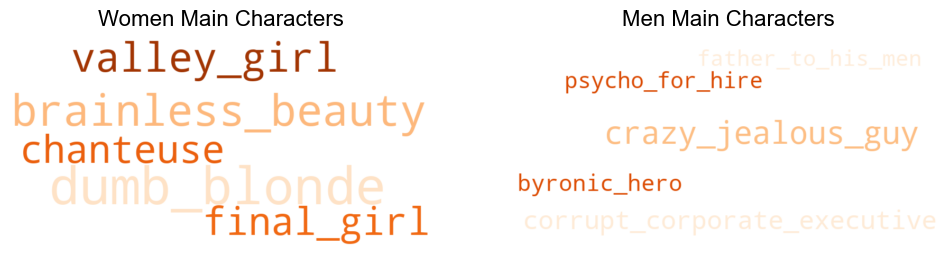

In [119]:
# Create WordClouds for women and men
women_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(women_counts)
men_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(men_counts)

# Plotting the WordClouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(women_wordcloud, interpolation='bilinear')
plt.title('Women Main Characters', color='black', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(men_wordcloud, interpolation='bilinear')
plt.title('Men Main Characters', color='black', fontsize=16)
plt.axis('off')

plt.show()

## PART 3: Analysis of the reception of movies by the public <a id="part2.3"></a>

### Is there a difference in revenue and popularity between female-dominated and male-dominated films?

We want to analyse whether the success of a movie is correlated with the proportion of women in a movie. To to this we will take the Box Office Revenue as a measure of success, as well as the IMDb ratings given around the world to each movie.

### Looking at the ratings

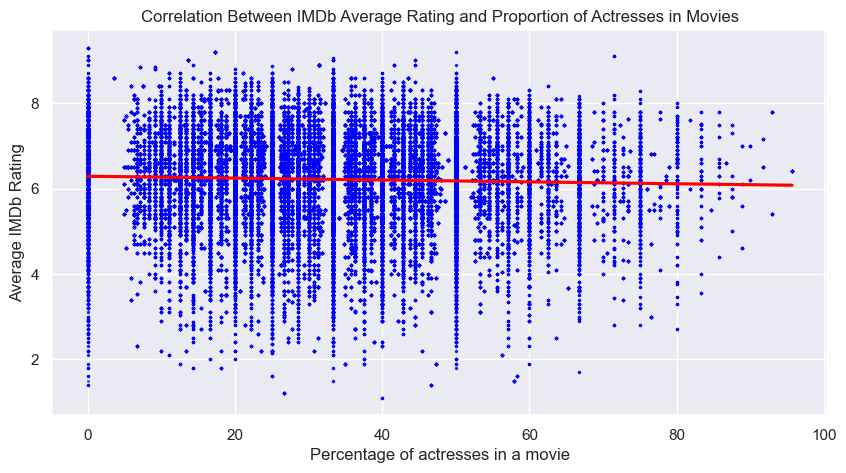

In [122]:
# We're interested only in movies for which we have information on gender distribution, so we perform a right join
ratings_gender = pd.merge(ratings, df_gender_proportion_by_movie_geo, on='WikiMovieID', how='right')

# Sort the values according to Percentage of Female 
ratings_gender.sort_values(by='PercentageofFemale', inplace=True)

plt.figure(figsize=(10,5))

sns.regplot(x=ratings_gender['PercentageofFemale'], y=ratings_gender['AverageRating'], ci=95, scatter_kws={'color': 'blue', 's': 2, 'alpha': 0.5}, line_kws={'color': 'red'})

plt.ylabel('Average IMDb Rating')
plt.xlabel('Percentage of actresses in a movie')

plt.title('Correlation Between IMDb Average Rating and Proportion of Actresses in Movies')

plt.show()

We do a linear regression to see the correlation between the percentage of women in movies and the rating given on IMDb. This shows us that there is a slight negative correlation, meaning that movies with a higher percentage of women tend to have a slightly worse rating. We need to check this with other statistical metrics. 

### Looking at the Box office revenue

Aside from how a movie has been rated on IMDb, it is also interesting to look at its comercial success. This gives another insight on how the movie was globally percieved and if it impacted a lot of people or not. Therefore we are now looking at the boxoffice revenue of movies where we have the information from the original CMU data set. 

/var/folders/xy/g9qngpq914dbt048l9v974zh0000gn/T/ipykernel_2900/2691133020.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



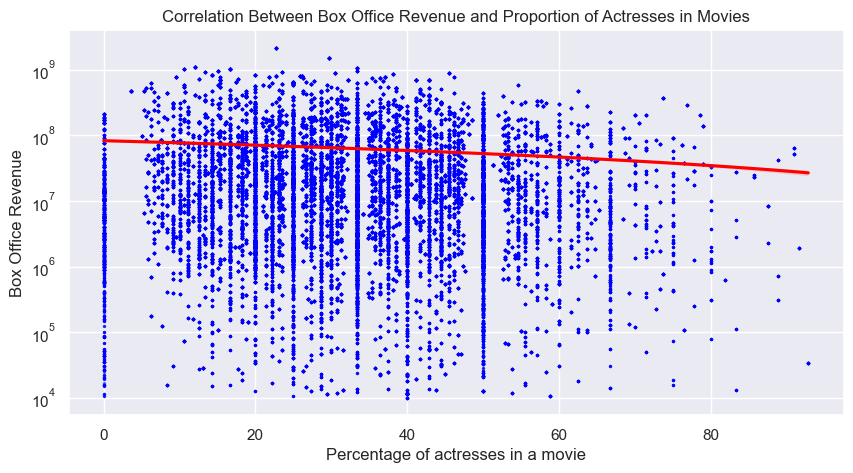

In [123]:
# Remove movies where we don't have the Box Office Revenue.
BO_ratings = ratings_gender.dropna(subset = 'BORevenue')

# Sort the values according to Percentage of Female 
BO_ratings.sort_values(by='PercentageofFemale', inplace=True)

plt.figure(figsize=(10,5))

sns.regplot(x=BO_ratings['PercentageofFemale'], y=BO_ratings['BORevenue'], ci=95, scatter_kws={'color': 'blue', 's': 2, 'alpha': 0.5}, line_kws={'color': 'red'})

plt.yscale("log")
plt.ylabel('Box Office Revenue')
plt.xlabel('Percentage of actresses in a movie')

plt.title('Correlation Between Box Office Revenue and Proportion of Actresses in Movies')

plt.show()

We do a linear regression to see the correlation between the percentage of women in movies and the Box Office Revenue. This shows us that there is a negative correlation, meaning that movies with a higher percentage of women tend to have a lower Box Office Revenue. We need to check this with other statistical metrics. 

### Causal Analysis: matching on release year bins, movie genre and country

In [124]:
def exact_match(columns, row1, row2):
    """
    Check if two rows are an exact match on specified columns.

    Parameters:
    - columns (list): List of column names to consider for the match.
    - control_row (pd.Series): Row from the control group.
    - treatment_row (pd.Series): Row from the treatment group.

    Returns:
    - bool: True if the rows are an exact match on the specified columns, False otherwise.
    """

    for col in columns:
        if row1[col] != row2[col] :
            return False
    
    return True

In [125]:
cmu_geo_without_duplicates = cmu_geo.drop_duplicates(subset=['WikiMovieID'], keep='first')

In [126]:
# We merge with df_gender_proportion_by_movie to get the proportion of women in the movie
cmu_gender = pd.merge(cmu_geo_without_duplicates, df_gender_proportion_by_movie_geo, on = ['WikiMovieID', 'ReleaseYear'], how = 'left')
cmu_gender = cmu_gender.dropna(subset=['PercentageofFemale'])

In [127]:
#Merge with the ratings dataset
ratings_without_duplicates = ratings.drop_duplicates(subset=['WikiMovieID'])
cmu_gender = pd.merge(cmu_gender, ratings_without_duplicates[['WikiMovieID', 'AverageRating']],on = ['WikiMovieID'], how= 'left' )
cmu_gender = cmu_gender.dropna(subset=['AverageRating'])

In [128]:
# Create bins for every 5 years starting from the minimum release year to the maximum release year
min_year = int(cmu_gender['ReleaseYear'].min())
max_year = int(cmu_gender['ReleaseYear'].max())
bins = list(range(min_year, max_year + 6, 5))  # Adding 6 to include the upper bound

# Create labels for the bins
labels = [f'{start}-{start+4}' for start in bins[:-1]]

# Use pd.cut to categorize release years into bins
cmu_gender['ReleaseYearBin'] = pd.cut(cmu_gender['ReleaseYear'], bins=bins, labels=labels, include_lowest=True)

In [129]:
med_female_prop = cmu_gender['PercentageofFemale'].median()

In [130]:
cmu_gender_high_F = cmu_gender[cmu_gender['PercentageofFemale'] >= med_female_prop]
cmu_gender_low_F = cmu_gender[cmu_gender['PercentageofFemale'] < med_female_prop]

In [ ]:
from tqdm.notebook import tqdm
import time

exact_match_columns = ['ReleaseYearBin', 'MovieGenre', 'Countries']

# Create an empty undirected graph
G_F = nx.Graph()

# Get the total number of pairs to iterate over
total_pairs = len(cmu_gender_high_F) * len(cmu_gender_low_F)

with tqdm(total=total_pairs, desc="Processing pairs") as pbar: # Progress bar
    # Loop through all the pairs of instances
    for high_F_id, high_F_row in cmu_gender_high_F.iterrows():
        for low_F_id, low_F_row in cmu_gender_low_F.iterrows():
            
            # Add an edge between the two instances if same track and same score before
            if exact_match(exact_match_columns, high_F_row, low_F_row):
                G_F.add_edge(high_F_id, low_F_id)
            
            # Update the progress bar and print time remaining
            pbar.update(1)
            pbar.set_postfix(time_left=pbar.format_interval(pbar._time()))
            time.sleep(0.1)

# Generate and return the maximum weight matching on the generated graph
pair_high_low_F = nx.maximal_matching(G_F)
print('The number of matching pairs is:', len(pair_high_low_F))


In [ ]:
save_pair_high_low_F = pair_high_low_F.copy()

In [ ]:
balanced_proportion_female_index = [i[0] for i in list(pair_high_low_F)]+ [i[1] for i in list(pair_high_low_F)] 
balanced_proportion_female = cmu_gender.loc[balanced_proportion_female_index]

In [ ]:
output_file = "balanced_proportion_female.tsv"
balanced_proportion_female.to_csv(output_file, sep='\t', index=False)

In [ ]:
reg_model = smf.ols(formula = ' AverageRating ~ PercentageofFemale', data = balanced_proportion_female)

results = reg_model.fit()
print(results.summary())

### Machine Learning with and without Percentage of Female

In [ ]:
#Keep only the name of the genre without its identifier
balanced_proportion_female['MovieGenre'] = balanced_proportion_female['MovieGenre'].apply(lambda x: list(x.values())[0])

In [ ]:
# one-hot encoding country and genre
one_hot_balanced_proportion_female = pd.get_dummies(balanced_proportion_female, columns =['Countries', 'MovieGenre'], prefix = '',prefix_sep='',dtype= int)

# normalize ReleaseYear column
one_hot_balanced_proportion_female['ReleaseYearNorm'] = (one_hot_balanced_proportion_female['ReleaseYear'] - one_hot_balanced_proportion_female['ReleaseYear'].mean())/ one_hot_balanced_proportion_female['ReleaseYear'].std()

# normalize ProportionofFemale (to have percentage betweeen 0 and 1)
one_hot_balanced_proportion_female['PercentageofFemale'] = one_hot_balanced_proportion_female['PercentageofFemale']/100

In [ ]:
col_Countries = balanced_proportion_female['Countries'].unique() 
col_MovieGenre = balanced_proportion_female['MovieGenre'].unique() 

In [ ]:
def numpy_helper(df, cols):
    '''
    Convert a DataFrame with N rows and a list of M columns to a np.array of dimension (NxM).

    Parameters:
    - df (pd.DataFrame): Input DataFrame with N rows.
    - cols (list): List of column names to be included in the resulting array.

    Returns:
    - np.array: np.array of dimension (NxM).
    '''

    array = df[cols].to_numpy(copy = True, dtype= float) 
    return array

In [ ]:
# Model 1
X_balanced_proportion_female = numpy_helper(one_hot_balanced_proportion_female, ['ReleaseYearNorm', 'PercentageofFemale'] + list(col_Countries)+list(col_MovieGenre))
y_ratings = one_hot_balanced_proportion_female['AverageRating']

# Create the Gradient Boosting Regressor model 1
gradient_boosting_reg_1 = GradientBoostingRegressor()

# Perform the cross validation
cv_result_1 = cross_validate(gradient_boosting_reg_1, X_balanced_proportion_female , y_ratings, cv=30, scoring=('neg_mean_squared_error', 'explained_variance'))
mse_1, exp_var_1 = cv_result_1['test_neg_mean_squared_error'], cv_result_1['test_explained_variance']

print(f'The average negative mse of model 1 is: {mse_1.mean():.3f}')
print(f'The explained variance of model 1 is: {exp_var_1.mean():.3f}')

In [ ]:
# Model 2
# X without the column Proportion of Female
X_balanced_proportion_female_without = numpy_helper(one_hot_balanced_proportion_female, ['ReleaseYearNorm' ] + list(col_Countries) + list(col_MovieGenre))

# Create the Gradient Boosting Regressor model 2
gradient_boosting_reg_2 = GradientBoostingRegressor()

# Perform the cross validation
cv_result_2 = cross_validate(gradient_boosting_reg_2, X_balanced_proportion_female_without , y_ratings, cv=30, scoring=('neg_mean_squared_error', 'explained_variance'))
mse_2, exp_var_2 = cv_result_2['test_neg_mean_squared_error'], cv_result_2['test_explained_variance']

print(f'The average negative mse of model 2 is: {mse_2.mean():.3f}')
print(f'The explained variance of model 2 is: {exp_var_2.mean():.3f}')

In [ ]:
# Perform the t-test
stats.ttest_rel(mse_1, mse_2)

### Analysis of the main character gender influence on the rating

In [135]:
main_char_rating = pd.merge(cmu_geo, credits, left_on=['MovieName', 'ActorName'], right_on=['title', 'main_actor'], how='inner')
main_char_rating

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,Continent,...,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,id,title,main_char,main_actor,main_char_gender
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},US,{'/m/01jfsb': 'Thriller'},2001.0,NA,...,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,10016,Ghosts of Mars,Lt. Melanie Ballard,Natasha Henstridge,F
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,{'/m/02h40lc': 'English Language'},US,{'/m/04t36': 'Musical'},1938.0,NA,...,Alice Faye,23.0,/m/02vbq8t,NaN,/m/032xfz,43839,Alexander's Ragtime Band,Stella Kirby,Alice Faye,F
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,{'/m/02h40lc': 'English Language'},GB,{'/m/07s9rl0': 'Drama'},1989.0,EU,...,Kenneth Branagh,28.0,/m/0jzbqf,/m/02nw8cd,/m/0prjs,10705,Henry V,Henry V,Kenneth Branagh,M
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,{'/m/02h40lc': 'English Language'},US,{'/m/04t36': 'Musical'},1964.0,NA,...,Julie Andrews,28.0,/m/0k0gys,/m/026sznm,/m/0kftt,433,Mary Poppins,Mary Poppins,Julie Andrews,F
4,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,{'/m/02h40lc': 'English Language'},US,{'/m/01jfsb': 'Thriller'},1999.0,NA,...,Christopher Walken,56.0,/m/02vbmy1,/m/0gy8nnx,/m/016fjj,21430,New Rose Hotel,Fox,Christopher Walken,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14903,25011340,/m/09gg54d,Dot.Kill,2005,NaN,{},US,{'/m/01jfsb': 'Thriller'},2005.0,NA,...,Armand Assante,55.0,/m/09j3mkk,NaN,/m/04mg6l,25707,Dot.Kill,Charlie Daines,Armand Assante,M
14904,25919941,/m/0b6lqy1,The Kreutzer Sonata,2008,NaN,{},US,{'/m/02l7c8': 'Romance Film'},2008.0,NA,...,Danny Huston,45.0,/m/0b6tg6s,NaN,/m/07vc_9,53315,The Kreutzer Sonata,Edgar,Danny Huston,M
14905,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,{'/m/02h40lc': 'English Language'},US,{'/m/0hqxf': 'Family Film'},1990.0,NA,...,Ariana Richards,10.0,/m/02tbfph,/m/0h4zl3h,/m/06j221,34086,Spaced Invaders,Kathy,Ariana Richards,F
14906,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,{},US,{'/m/01jfsb': 'Thriller'},1993.0,NA,...,Rebecca De Mornay,33.0,/m/03lqyhw,NaN,/m/0bvxd,4916,Guilty as Sin,Jennifer Haines,Rebecca De Mornay,F


In [136]:
main_char_rating= main_char_rating.drop_duplicates(subset='WikiMovieID')
display(main_char_rating)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,Continent,...,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,id,title,main_char,main_actor,main_char_gender
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},US,{'/m/01jfsb': 'Thriller'},2001.0,NA,...,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,10016,Ghosts of Mars,Lt. Melanie Ballard,Natasha Henstridge,F
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,{'/m/02h40lc': 'English Language'},US,{'/m/04t36': 'Musical'},1938.0,NA,...,Alice Faye,23.0,/m/02vbq8t,NaN,/m/032xfz,43839,Alexander's Ragtime Band,Stella Kirby,Alice Faye,F
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,{'/m/02h40lc': 'English Language'},GB,{'/m/07s9rl0': 'Drama'},1989.0,EU,...,Kenneth Branagh,28.0,/m/0jzbqf,/m/02nw8cd,/m/0prjs,10705,Henry V,Henry V,Kenneth Branagh,M
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,{'/m/02h40lc': 'English Language'},US,{'/m/04t36': 'Musical'},1964.0,NA,...,Julie Andrews,28.0,/m/0k0gys,/m/026sznm,/m/0kftt,433,Mary Poppins,Mary Poppins,Julie Andrews,F
4,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,{'/m/02h40lc': 'English Language'},US,{'/m/01jfsb': 'Thriller'},1999.0,NA,...,Christopher Walken,56.0,/m/02vbmy1,/m/0gy8nnx,/m/016fjj,21430,New Rose Hotel,Fox,Christopher Walken,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14903,25011340,/m/09gg54d,Dot.Kill,2005,NaN,{},US,{'/m/01jfsb': 'Thriller'},2005.0,NA,...,Armand Assante,55.0,/m/09j3mkk,NaN,/m/04mg6l,25707,Dot.Kill,Charlie Daines,Armand Assante,M
14904,25919941,/m/0b6lqy1,The Kreutzer Sonata,2008,NaN,{},US,{'/m/02l7c8': 'Romance Film'},2008.0,NA,...,Danny Huston,45.0,/m/0b6tg6s,NaN,/m/07vc_9,53315,The Kreutzer Sonata,Edgar,Danny Huston,M
14905,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,{'/m/02h40lc': 'English Language'},US,{'/m/0hqxf': 'Family Film'},1990.0,NA,...,Ariana Richards,10.0,/m/02tbfph,/m/0h4zl3h,/m/06j221,34086,Spaced Invaders,Kathy,Ariana Richards,F
14906,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,{},US,{'/m/01jfsb': 'Thriller'},1993.0,NA,...,Rebecca De Mornay,33.0,/m/03lqyhw,NaN,/m/0bvxd,4916,Guilty as Sin,Jennifer Haines,Rebecca De Mornay,F


In [137]:
main_char_rating= pd.merge(main_char_rating, ratings_without_duplicates[['WikiMovieID', 'AverageRating']],on = ['WikiMovieID'], how= 'inner' )
main_char_rating = main_char_rating.dropna(subset='AverageRating')

In [138]:
display(main_char_rating)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,Continent,...,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,id,title,main_char,main_actor,main_char_gender,AverageRating
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},US,{'/m/01jfsb': 'Thriller'},2001.0,NA,...,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,10016,Ghosts of Mars,Lt. Melanie Ballard,Natasha Henstridge,F,4.900000
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,{'/m/02h40lc': 'English Language'},US,{'/m/04t36': 'Musical'},1938.0,NA,...,23.0,/m/02vbq8t,NaN,/m/032xfz,43839,Alexander's Ragtime Band,Stella Kirby,Alice Faye,F,6.800000
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,{'/m/02h40lc': 'English Language'},GB,{'/m/07s9rl0': 'Drama'},1989.0,EU,...,28.0,/m/0jzbqf,/m/02nw8cd,/m/0prjs,10705,Henry V,Henry V,Kenneth Branagh,M,7.497131
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,{'/m/02h40lc': 'English Language'},US,{'/m/04t36': 'Musical'},1964.0,NA,...,28.0,/m/0k0gys,/m/026sznm,/m/0kftt,433,Mary Poppins,Mary Poppins,Julie Andrews,F,7.800000
5,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,{'/m/02h40lc': 'English Language'},US,{'/m/0lsxr': 'Crime Fiction'},2001.0,NA,...,22.0,/m/0jtx5h,/m/03jnxf4,/m/01l1b90,16161,Baby Boy,Joseph Summers,Tyrese Gibson,M,6.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14562,21772949,/m/05mspcd,Casbah,1948-04,NaN,{'/m/02h40lc': 'English Language'},US,{'/m/0lsxr': 'Crime Fiction'},1948.0,NA,...,NaN,/m/0bx29h6,/m/0h5jrjn,/m/033hwk,45628,Casbah,Inez,Yvonne De Carlo,F,6.000000
14564,25919941,/m/0b6lqy1,The Kreutzer Sonata,2008,NaN,{},US,{'/m/02l7c8': 'Romance Film'},2008.0,NA,...,45.0,/m/0b6tg6s,NaN,/m/07vc_9,53315,The Kreutzer Sonata,Edgar,Danny Huston,M,5.600000
14565,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,{'/m/02h40lc': 'English Language'},US,{'/m/0hqxf': 'Family Film'},1990.0,NA,...,10.0,/m/02tbfph,/m/0h4zl3h,/m/06j221,34086,Spaced Invaders,Kathy,Ariana Richards,F,5.300000
14566,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,{},US,{'/m/01jfsb': 'Thriller'},1993.0,NA,...,33.0,/m/03lqyhw,NaN,/m/0bvxd,4916,Guilty as Sin,Jennifer Haines,Rebecca De Mornay,F,5.700000


In [139]:
# Create bins for every 5 years starting from the minimum release year to the maximum release year
min_year = int(main_char_rating['ReleaseYear'].min())
max_year = int(main_char_rating['ReleaseYear'].max())
bins = list(range(min_year, max_year + 6, 5))  # Adding 6 to include the upper bound

# Create labels for the bins
labels = [f'{start}-{start+4}' for start in bins[:-1]]

# Use pd.cut to categorize release years into bins
main_char_rating['ReleaseYearBin'] = pd.cut(main_char_rating['ReleaseYear'], bins=bins, labels=labels, include_lowest=True)

In [140]:
main_char_rating

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,Continent,...,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,id,title,main_char,main_actor,main_char_gender,AverageRating,ReleaseYearBin
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},US,{'/m/01jfsb': 'Thriller'},2001.0,NA,...,/m/0jys3m,/m/0bgchn4,/m/0346l4,10016,Ghosts of Mars,Lt. Melanie Ballard,Natasha Henstridge,F,4.900000,2000-2004
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,{'/m/02h40lc': 'English Language'},US,{'/m/04t36': 'Musical'},1938.0,NA,...,/m/02vbq8t,NaN,/m/032xfz,43839,Alexander's Ragtime Band,Stella Kirby,Alice Faye,F,6.800000,1935-1939
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,{'/m/02h40lc': 'English Language'},GB,{'/m/07s9rl0': 'Drama'},1989.0,EU,...,/m/0jzbqf,/m/02nw8cd,/m/0prjs,10705,Henry V,Henry V,Kenneth Branagh,M,7.497131,1985-1989
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,{'/m/02h40lc': 'English Language'},US,{'/m/04t36': 'Musical'},1964.0,NA,...,/m/0k0gys,/m/026sznm,/m/0kftt,433,Mary Poppins,Mary Poppins,Julie Andrews,F,7.800000,1960-1964
5,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,{'/m/02h40lc': 'English Language'},US,{'/m/0lsxr': 'Crime Fiction'},2001.0,NA,...,/m/0jtx5h,/m/03jnxf4,/m/01l1b90,16161,Baby Boy,Joseph Summers,Tyrese Gibson,M,6.400000,2000-2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14562,21772949,/m/05mspcd,Casbah,1948-04,NaN,{'/m/02h40lc': 'English Language'},US,{'/m/0lsxr': 'Crime Fiction'},1948.0,NA,...,/m/0bx29h6,/m/0h5jrjn,/m/033hwk,45628,Casbah,Inez,Yvonne De Carlo,F,6.000000,1945-1949
14564,25919941,/m/0b6lqy1,The Kreutzer Sonata,2008,NaN,{},US,{'/m/02l7c8': 'Romance Film'},2008.0,NA,...,/m/0b6tg6s,NaN,/m/07vc_9,53315,The Kreutzer Sonata,Edgar,Danny Huston,M,5.600000,2005-2009
14565,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,{'/m/02h40lc': 'English Language'},US,{'/m/0hqxf': 'Family Film'},1990.0,NA,...,/m/02tbfph,/m/0h4zl3h,/m/06j221,34086,Spaced Invaders,Kathy,Ariana Richards,F,5.300000,1985-1989
14566,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,{},US,{'/m/01jfsb': 'Thriller'},1993.0,NA,...,/m/03lqyhw,NaN,/m/0bvxd,4916,Guilty as Sin,Jennifer Haines,Rebecca De Mornay,F,5.700000,1990-1994


In [141]:
main_char_rating = main_char_rating[['WikiMovieID', 'MovieName', 'Countries', 'MovieGenre', 'main_char_gender', 'AverageRating', 'ReleaseYearBin', 'ReleaseYear']].copy(deep=True)

In [142]:
main_char_rating

,WikiMovieID,MovieName,Countries,MovieGenre,main_char_gender,AverageRating,ReleaseYearBin,ReleaseYear
0,975900,Ghosts of Mars,US,{'/m/01jfsb': 'Thriller'},F,4.900000,2000-2004,2001.0
1,10408933,Alexander's Ragtime Band,US,{'/m/04t36': 'Musical'},F,6.800000,1935-1939,1938.0
2,171005,Henry V,GB,{'/m/07s9rl0': 'Drama'},M,7.497131,1985-1989,1989.0
3,77856,Mary Poppins,US,{'/m/04t36': 'Musical'},F,7.800000,1960-1964,1964.0
5,156558,Baby Boy,US,{'/m/0lsxr': 'Crime Fiction'},M,6.400000,2000-2004,2001.0
...,...,...,...,...,...,...,...,...
14562,21772949,Casbah,US,{'/m/0lsxr': 'Crime Fiction'},F,6.000000,1945-1949,1948.0
14564,25919941,The Kreutzer Sonata,US,{'/m/02l7c8': 'Romance Film'},M,5.600000,2005-2009,2008.0
14565,7761830,Spaced Invaders,US,{'/m/0hqxf': 'Family Film'},F,5.300000,1985-1989,1990.0
14566,664006,Guilty as Sin,US,{'/m/01jfsb': 'Thriller'},F,5.700000,1990-1994,1993.0


In [143]:
main_char_rating_female = main_char_rating[main_char_rating['main_char_gender'] == 'F']
main_char_rating_male = main_char_rating[main_char_rating['main_char_gender'] == 'M']

In [ ]:
main_char_rating_male

In [ ]:
exact_match_columns = ['ReleaseYearBin', 'MovieGenre', 'Countries']

# Create an empty undirected graph
G_Main_Char = nx.Graph()

i = 0

# Loop through all the pairs of instances
for main_char_M_id, main_char_M_row in main_char_rating_male.iterrows():
    i = i+1
    print(f'Row {i} out of 8623')
    for main_char_F_id, main_char_F_row in main_char_rating_female.iterrows():
        
        # Add an edge between the two instances if same track and same score before
        if exact_match(exact_match_columns, main_char_M_row, main_char_F_row):
            G_Main_Char.add_edge(main_char_M_id, main_char_F_id)

print('loop finished')
# Generate and return the maximum weight matching on the generated graph
pair_main_char_gender = nx.maximal_matching(G_Main_Char)
print('The number of matching pairs is:', len(pair_main_char_gender))

In [ ]:
balanced_main_char_index = [i[0] for i in list(pair_main_char_gender)]+ [i[1] for i in list(pair_main_char_gender)] 
balanced_main_char = main_char_rating.loc[balanced_main_char_index]

In [ ]:
balanced_main_char = pd.get_dummies(balanced_main_char, columns =['main_char_gender'], prefix = '',prefix_sep='', dtype= int)
balanced_main_char.rename(columns={'F': 'MainCharFemale', 'M': 'MainCharMale'}, inplace=True)
display(balanced_main_char)

#### Linear Regression

In [ ]:
reg_model_main_char = smf.ols(formula = 'AverageRating ~ MainCharFemale + MainCharMale', data = balanced_main_char)

results_main_char = reg_model_main_char.fit()
print(results_main_char.summary())

In [ ]:
#Test if the difference between the coefficients is significant

coeff_F, coeff_M = results_main_char.params['MainCharFemale'],results_main_char.params['MainCharMale']
std_e_F, std_e_M = results_main_char.bse['MainCharFemale'],results_main_char.bse['MainCharMale']

test_statistic = (coeff_F - coeff_M) / ((std_e_F**2) + (std_e_M**2))**0.5

#Two-tailed critical value for a 95% Confidence Interval
critical_value = 1.96

if abs(test_statistic) > critical_value:
    print('The difference between the coefficients is significant')
else : 
    print('The difference between the coefficients is not significant')

#### GradientBoostingRegression

In [ ]:
#Keep only the name of the genre without its identifier
balanced_main_char['MovieGenre'] = balanced_main_char['MovieGenre'].apply(lambda x: list(x.values())[0])

In [ ]:
# one-hot encoding country and genre
one_hot_balanced_main_char = pd.get_dummies(balanced_main_char, columns =['Countries', 'MovieGenre'], prefix = '',prefix_sep='',dtype= int)

#Add the ReleaseYearcolumn
one_hot_balanced_main_char = pd.merge(one_hot_balanced_main_char, cmu_geo_without_duplicates[['WikiMovieID', 'ReleaseYear']], on = 'WikiMovieID', how='left')

# normalize ReleaseYear column
one_hot_balanced_main_char['ReleaseYearNorm'] = (one_hot_balanced_main_char['ReleaseYear'] - one_hot_balanced_main_char['ReleaseYear'].mean())/ one_hot_balanced_main_char['ReleaseYear'].std()

In [ ]:
one_hot_balanced_main_char

In [ ]:
col_Countries = balanced_main_char['Countries'].unique() 
col_MovieGenre = balanced_main_char['MovieGenre'].unique() 

In [ ]:
# Model 1
X_balanced_main_char = numpy_helper(one_hot_balanced_main_char, ['ReleaseYearNorm', 'MainCharFemale', 'MainCharMale'] + list(col_Countries)+list(col_MovieGenre))
y_ratings = one_hot_balanced_main_char['AverageRating']

# Create the Gradient Boosting Regressor model 1
gradient_boosting_reg_1 = GradientBoostingRegressor()

# Perform the cross validation
cv_result_1 = cross_validate(gradient_boosting_reg_1, X_balanced_main_char , y_ratings, cv=30, scoring=('neg_mean_squared_error', 'explained_variance'))
mse_1, exp_var_1 = cv_result_1['test_neg_mean_squared_error'], cv_result_1['test_explained_variance']

print(f'The average negative mse of model 1 is: {mse_1.mean():.3f}')
print(f'The explained variance of model 1 is: {exp_var_1.mean():.3f}')

In [ ]:
# Model 2
X_balanced_main_char_without_gender = numpy_helper(one_hot_balanced_main_char, ['ReleaseYearNorm'] + list(col_Countries)+list(col_MovieGenre))
y_ratings = one_hot_balanced_main_char['AverageRating']

# Create the Gradient Boosting Regressor model 1
gradient_boosting_reg_2 = GradientBoostingRegressor()

# Perform the cross validation
cv_result_2 = cross_validate(gradient_boosting_reg_2, X_balanced_main_char_without_gender , y_ratings, cv=30, scoring=('neg_mean_squared_error', 'explained_variance'))
mse_2, exp_var_2 = cv_result_2['test_neg_mean_squared_error'], cv_result_2['test_explained_variance']

print(f'The average negative mse of model 2 is: {mse_2.mean():.3f}')
print(f'The explained variance of model 2 is: {exp_var_2.mean():.3f}')

In [ ]:
# Perform the t-test
stats.ttest_rel(mse_1, mse_2)

### Analysis of the main character gender influence on award nomination

In [131]:
award_categories = set(awards['Category'])
sorted_categories = sorted(award_categories)
print('Award categories:\n',sorted_categories)

Award categories:
 ['ACTOR', 'ACTOR IN A LEADING ROLE', 'ACTOR IN A SUPPORTING ROLE', 'ACTRESS', 'ACTRESS IN A LEADING ROLE', 'ACTRESS IN A SUPPORTING ROLE', 'ANIMATED FEATURE FILM', 'ART DIRECTION', 'ART DIRECTION (Black-and-White)', 'ART DIRECTION (Color)', 'ASSISTANT DIRECTOR', 'AWARD OF COMMENDATION', 'BEST MOTION PICTURE', 'BEST PICTURE', 'CINEMATOGRAPHY', 'CINEMATOGRAPHY (Black-and-White)', 'CINEMATOGRAPHY (Color)', 'COSTUME DESIGN', 'COSTUME DESIGN (Black-and-White)', 'COSTUME DESIGN (Color)', 'DANCE DIRECTION', 'DIRECTING', 'DIRECTING (Comedy Picture)', 'DIRECTING (Dramatic Picture)', 'DOCUMENTARY', 'DOCUMENTARY (Feature)', 'DOCUMENTARY (Short Subject)', 'DOCUMENTARY FEATURE FILM', 'DOCUMENTARY SHORT FILM', 'ENGINEERING EFFECTS', 'FILM EDITING', 'FOREIGN LANGUAGE FILM', 'INTERNATIONAL FEATURE FILM', 'MAKEUP', 'MAKEUP AND HAIRSTYLING', 'MUSIC (Adaptation Score)', 'MUSIC (Music Score of a Dramatic Picture)', 'MUSIC (Music Score of a Dramatic or Comedy Picture)', 'MUSIC (Music Sco

In [132]:
gendered_categories = {'ACTOR', 'ACTRESS', 'ACTOR IN A LEADING ROLE', 'ACTRESS IN A LEADING ROLE', 'ACTOR IN A SUPPORTING ROLE', 
                       'ACTRESS IN A SUPPORTING ROLE'}

non_gendered_awards = awards[~awards['Category'].isin(gendered_categories)]

In [144]:
awards_main_char_rating = pd.merge(main_char_rating, non_gendered_awards, on=['MovieName', 'ReleaseYear'], how='right')
display(awards_main_char_rating)

,WikiMovieID,MovieName,Countries,MovieGenre,main_char_gender,AverageRating,ReleaseYearBin,ReleaseYear,CeremonyYear,Ceremony,Category,NomineeName,Winner
0,NaN,Sunrise,NaN,NaN,NaN,NaN,NaN,1927.0,1928,1,ART DIRECTION,Rochus Gliese,False
1,NaN,The Dove;,NaN,NaN,NaN,NaN,NaN,1927.0,1928,1,ART DIRECTION,William Cameron Menzies,True
2,NaN,7th Heaven,NaN,NaN,NaN,NaN,NaN,1927.0,1928,1,ART DIRECTION,Harry Oliver,False
3,NaN,The Devil Dancer;,NaN,NaN,NaN,NaN,NaN,1927.0,1928,1,CINEMATOGRAPHY,George Barnes,False
4,NaN,Sunrise,NaN,NaN,NaN,NaN,NaN,1927.0,1928,1,CINEMATOGRAPHY,Charles Rosher,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8637,NaN,Everything Everywhere All at Once,NaN,NaN,NaN,NaN,NaN,2022.0,2023,95,WRITING (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,True
8638,NaN,The Fabelmans,NaN,NaN,NaN,NaN,NaN,2022.0,2023,95,WRITING (Original Screenplay),Written by Steven Spielberg & Tony Kushner,False
8639,NaN,Tár,NaN,NaN,NaN,NaN,NaN,2022.0,2023,95,WRITING (Original Screenplay),Written by Todd Field,False
8640,NaN,Triangle of Sadness,NaN,NaN,NaN,NaN,NaN,2022.0,2023,95,WRITING (Original Screenplay),Written by Ruben Östlund,False


In [145]:
awards_main_char_rating = awards_main_char_rating.dropna(subset=['AverageRating'])

In [146]:
print('The number of movies in the dataset is:', awards_main_char_rating['WikiMovieID'].nunique())

The number of movies in the dataset is: 1549


## PART 4: Analysis by geographical production region <a id="part2.4"></a>

### Do we have enough movies per continent ?

In [153]:
# Keep only 1 row per movie to count the number of movies per continent
cmu_countries_filtered = cmu_geo.drop_duplicates(subset=['MovieName', 'ReleaseYear', 'Continent'])
counts_per_continent = cmu_countries_filtered.groupby('Continent').size()

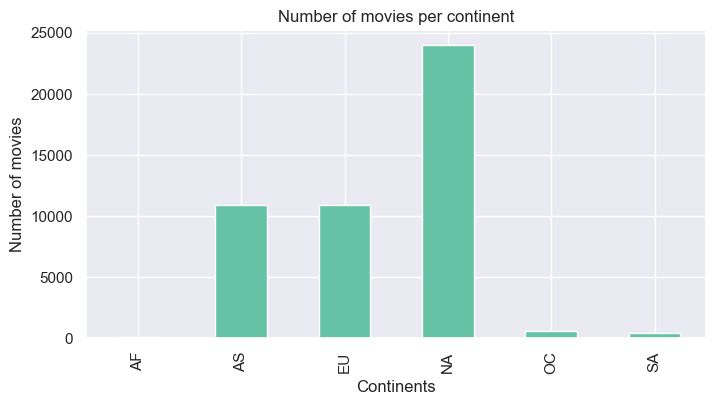

In [154]:
plt.figure(figsize=(8, 4))
counts_per_continent.plot(kind='bar')

plt.xlabel('Continents')
plt.ylabel('Number of movies')
plt.title('Number of movies per continent')

plt.show()

## Matching on ReleaseYear and Genre

Te be able to make causal conclusions with the data we have, we decided to perform matching. The goal is to obtain a dataset where the biggest confounders are balanced. We decided to match on the release year of the movies (in bins of 5 years) and on the main genre of the movie, as  we think those might influence the proportion of women in the movie. We do not match on Box office revenue or IMDB score because we don't think it is an important confounder for the coutry or the female proportion. This way the main difference remaining between the movies is the region of production. 

In [155]:
# Create bins for every 5 years starting from the minimum release year to the maximum release year
min_year = int(cmu_countries_filtered['ReleaseYear'].min())
max_year = int(cmu_countries_filtered['ReleaseYear'].max())
bins = list(range(min_year, max_year + 6, 5))  # Adding 6 to include the upper bound

# Create labels for the bins
labels = [f'{start}-{start+4}' for start in bins[:-1]]

# Use pd.cut to categorize release years into bins
cmu_countries_filtered['ReleaseYearBin'] = pd.cut(cmu_countries_filtered['ReleaseYear'], bins=bins, labels=labels, include_lowest=True)

/var/folders/xy/g9qngpq914dbt048l9v974zh0000gn/T/ipykernel_2900/4063912378.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [157]:
# We merge with df_gender_proportion_by_movie to get the proportion of women in the movie
cmu_countries_filtered = cmu_countries_filtered.merge(df_gender_proportion_by_movie_geo[['WikiMovieID', 'PercentageofFemale']], on = 'WikiMovieID', how = 'inner')
cmu_countries_filtered.dropna(subset='PercentageofFemale')

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Languages,Countries,MovieGenre,ReleaseYear,Continent,CharacterName,Gender,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYearBin,PercentageofFemale
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,{'/m/02h40lc': 'English Language'},US,{'/m/01jfsb': 'Thriller'},2001.0,NA,Akooshay,F,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2000-2004,35.294118
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,{'/m/02h40lc': 'English Language'},US,{'/m/07s9rl0': 'Drama'},2000.0,NA,Police Officer,M,NaN,Allen Cutler,NaN,/m/0lr37fl,/m/0lr3z80,/m/0h8pnlw,1995-1999,26.666667
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,{'/m/05f_3': 'Norwegian Language'},NO,{'/m/0lsxr': 'Crime Fiction'},1988.0,EU,NaN,M,NaN,Frank Krog,33.0,/m/0gct1bn,NaN,/m/053j7xf,1985-1989,50.000000
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,{'/m/02h40lc': 'English Language'},GB,{'/m/01jfsb': 'Thriller'},1987.0,EU,NaN,M,NaN,David Keith,32.0,/m/02t9_0c,NaN,/m/036496,1985-1989,50.000000
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,{'/m/04306rv': 'German Language'},DE,{'/m/07s9rl0': 'Drama'},1983.0,EU,NaN,F,NaN,Gudrun Landgrebe,32.0,/m/02vb3cv,NaN,/m/09d6hv,1980-1984,33.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44743,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,{'/m/02h40lc': 'English Language'},GB,{'/m/0lsxr': 'Crime Fiction'},1941.0,EU,NaN,F,NaN,Kathleen Harrison,NaN,/m/0cf_nn2,NaN,/m/04d7mh,1940-1944,36.363636
44744,32468537,/m/0crwd9y,Shadow Boxing 2,2007-10-18,NaN,"{'/m/06b_j': 'Russian Language', '/m/02h40lc':...",RU,{'/m/0lsxr': 'Crime Fiction'},2007.0,EU,NaN,M,NaN,Andrei Panin,45.0,/m/0h1ks15,NaN,/m/03nnxgl,2005-2009,14.285714
44745,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,{'/m/02h40lc': 'English Language'},US,{'/m/01z4y': 'Comedy'},1972.0,NA,NaN,M,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,1970-1974,0.000000
44746,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,{'/m/03_9r': 'Japanese Language'},JP,{'/m/03k9fj': 'Adventure'},1992.0,AS,Mesena,M,NaN,Isshin Chiba,23.0,/m/0kr40bw,/m/0kr40b_,/m/04xwsh,1990-1994,33.333333


In [158]:
# divide dataset according to region of interest
cmu_eu = cmu_countries_filtered[cmu_countries_filtered['Continent']== 'EU']
cmu_us = cmu_countries_filtered[cmu_countries_filtered['Countries']== 'US']
cmu_in = cmu_countries_filtered[cmu_countries_filtered['Countries']== 'IN']

In [ ]:
exact_match_columns = ['ReleaseYearBin', 'MovieGenre']

# Create an empty undirected graph
G_eu_in = nx.Graph()

# Loop through all the pairs of instances
for eu_id, eu_row in cmu_eu.iterrows():
    for in_id, in_row in cmu_in.iterrows():
        
        # Add an edge between the two instances if same track and same score before
        if exact_match(exact_match_columns, eu_row, in_row):
            G_eu_in.add_edge(eu_id, in_id)

# Generate and return the maximum weight matching on the generated graph
pair_eu_in = nx.maximal_matching(G_eu_in)
print('The number of matching pairs is:', len(pair_eu_in))

In [ ]:
eu_in_matched = [i[0] for i in list(pair_eu_in)]+  [i[1] for i in list(pair_eu_in)] 
df_pair_eu_in= cmu_countries_filtered.loc[eu_in_matched]

In [ ]:
eu_from_pair_eu_in = df_pair_eu_in[df_pair_eu_in['Continent']=='EU']
in_from_pair_eu_in = df_pair_eu_in[df_pair_eu_in['Countries']=='IN']

In [ ]:
# Create an empty undirected graph
G_eu_us = nx.Graph()

nb_row = len(eu_from_pair_eu_in)
# Loop through all the pairs of instances
for eu_id, eu_row in eu_from_pair_eu_in.iterrows():
    for us_id, us_row in cmu_us.iterrows():
    
        # Add an edge between the two instances if same track and same score before
        if exact_match(exact_match_columns, eu_row, us_row):
            G_eu_us.add_edge(eu_id, us_id)

# Generate and return the maximum weight matching on the generated graph
pair_eu_us = nx.maximal_matching(G_eu_us)
print('The number of matching pairs is:', len(pair_eu_us))

In [ ]:
eu_us_matched = [i[0] for i in list(pair_eu_us)]+  [i[1] for i in list(pair_eu_us)] 
df_pair_eu_us= cmu_countries_filtered.loc[eu_us_matched]
display(df_pair_eu_us)

In [ ]:
eu_from_pair_eu_us = df_pair_eu_us[df_pair_eu_us['Continent']=='EU']
us_from_pair_eu_us = df_pair_eu_us[df_pair_eu_us['Countries']=='US']
display(eu_from_pair_eu_us)

In [ ]:
id_pair_eu_in = []
for pair in pair_eu_in:
    if df_pair_eu_in['Countries'].loc[pair[0]] == 'IN':
        new_row = [pair[1], pair[0]]
    else :
        new_row = [pair[0], pair[1]]
    id_pair_eu_in.append(new_row)

In [ ]:
id_pair_eu_us = []
for pair in pair_eu_us:
    if df_pair_eu_us['Countries'].loc[pair[0]] == 'US':
        new_row = [pair[1], pair[0]]
    else :
        new_row = [pair[0], pair[1]]
    id_pair_eu_us.append(new_row)

In [ ]:
eu_selected = np.intersect1d([pair[0] for pair in id_pair_eu_us], [pair[0] for pair in id_pair_eu_in])
us_selected = [pair[1] for pair in id_pair_eu_us]

In [ ]:
dict_id_pair_eu_in = dict(id_pair_eu_in)
in_selected = [dict_id_pair_eu_in[eu_id] for eu_id in eu_selected]

In [ ]:
id_perfect_matched_movies = list(eu_selected) + list(in_selected) + list(us_selected)

In [ ]:
balanced_geo = cmu_countries_filtered.loc[id_perfect_matched_movies]
balanced_geo


## ANOVA
We want to assess the causal impact of the geographical region of production of a movie on the proportion of female


In [ ]:
# Separate according to region
balanced_eu = balanced_geo[balanced_geo['Continent']== 'EU']
balanced_us = balanced_geo[balanced_geo['Countries']== 'US']
balanced_in = balanced_geo[balanced_geo['Countries']== 'IN']

In [ ]:
stats.f_oneway(balanced_eu['PercentageofFemale'],balanced_us['PercentageofFemale'],balanced_in['PercentageofFemale'])

The p-value is smaller than 0.05, this implies that the difference in the percentage of female is significantly different in at least one of the three regions. Howerver, this does not tell us which groups are different from each other. We therefore must conduct a post hoc test, the Tukey's test allows to make pairwise comparisons between the means of each group.

## Tukey's Test

In [ ]:
tukey_df = balanced_geo[['WikiMovieID', 'PercentageofFemale', 'Countries']]

# Transform Countries colum to have US, IN or EU:
tukey_df['Countries'] = tukey_df['Countries'].apply(lambda x: 'EU' if (x != 'US' and x != 'IN') else x)

tukey_test = pairwise_tukeyhsd(endog = tukey_df['PercentageofFemale'], groups = tukey_df['Countries'], alpha = 0.05)

print(tukey_test)
